In [1]:
import numpy as np
import cv2
import os
import math
import numpy.linalg as linalg
import sys
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.signal
import sqlite3
%matplotlib inline 
import pickle

In [16]:
from keras.models import *

In [2]:
import keras
import keras.backend as K
from keras.layers import *

c:\anaconda\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
vgg19 = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [4]:
def GetTransformationParams(img_src_shape, img_dst_shape, K_cam1, K_cam2, z, cam_shift=[0,0,0], debug=False):
    
    # Generate a vector of points on a plane
    P = np.zeros( ( img_src_shape[0]*img_src_shape[1],3 ), dtype=np.float32 )
    i = 0
    for x in range(img_src_shape[1]):
        for y in range(img_src_shape[0]):
            P[i,0] = x
            P[i,1] = y
            P[i,2] = 1
            i+=1

    K_cam1_inv = linalg.inv(K_cam1)
    P_out = np.matmul(  K_cam1_inv, np.transpose(P) )
    P_out = np.transpose(P_out)
    if debug:
        print(P_out.shape)
    for i in range(0, P_out.shape[0]):
        s = z/P_out[i,2]
        P_out[i,0] = P_out[i,0]*s
        P_out[i,1] = P_out[i,1]*s
        P_out[i,2] = P_out[i,2]*s
        
        
    I = np.eye(3, dtype=np.float32)
    C = np.array( [ 40, 0,0 ], dtype=np.float32 ) # do we even use it?
    IC = np.zeros((3,4), dtype=np.float32)
    IC[0:3, 0:3] = I
    IC[0, 3] = cam_shift[0]     
    IC[1, 3] = cam_shift[1]     
    IC[2, 3] = cam_shift[2]     
    
    KIC = np.matmul(K_cam2, IC)
    
    # Generate homogeneous coordinates
    o = np.ones((P_out.shape[0],1), dtype=np.float32)
    P_out_4D = np.hstack((P_out, o))

    # Transform
    out = np.matmul( KIC, np.transpose(P_out_4D))
    out = np.transpose(out)
    out[:,0] = np.divide(out[:,0], out[:,2])
    out[:,1] = np.divide(out[:,1], out[:,2])
    out[:,2] = np.divide(out[:,2], out[:,2])

    p_out = out.astype(np.int64)
    p_in = P.astype(np.int64)
    coords_src = []
    coords_dst = []
    for i in range(0, out.shape[0]):
#        img[ p_out[1], p_out[0],: ] = img_col[ p_in[1], p_in[0], : ]
        if p_out[i,0] < 0 or p_out[i,1] < 0 or p_in[i,0] < 0 or p_out[i,1] < 0 :
            continue
        coords_src.append([  ])
    
    return P.astype(np.int64), out.astype(np.int64)


#GetTransformationParams(img_col.shape, img_ir.shape, K_Color, K_IR, 2500.0, cam_shift=[26,-35,0])

In [5]:
def CameraMatrix(fx, fy, cx, cy):
    K = np.array([ [fx, 0, cx], [0, fy, cy ], [0,0,1] ])
    return K

def TransformCameraOnZPlane(img_col, img_ir, K_cam1, K_cam2, z, cam_shift=[0,0,0], coords_in=None, debug=False):
    
    if coords_in is None:
        # Generate a vector of points on a plane
        P = np.zeros( ( img_col.shape[0]*img_col.shape[1],3 ), dtype=np.float32 )
        i = 0
        for x in range(img_col.shape[1]):
            for y in range(img_col.shape[0]):
                P[i,0] = x
                P[i,1] = y
                P[i,2] = 1
                i+=1
    else:
        P = coords_in

    if debug:
        print('P shape:')
        print(P.shape)
    K_cam1_inv = linalg.inv(K_cam1)
    P_out = np.matmul(  K_cam1_inv, np.transpose(P) )
    P_out = np.transpose(P_out)
    if debug:
        print(P_out.shape)
    for i in range(0, P_out.shape[0]):
        s = z/P_out[i,2]
        P_out[i,0] = P_out[i,0]*s
        P_out[i,1] = P_out[i,1]*s
        P_out[i,2] = P_out[i,2]*s
        
        
    I = np.eye(3, dtype=np.float32)
    C = np.array( [ 40, 0,0 ], dtype=np.float32 ) # do we even use it?
    IC = np.zeros((3,4), dtype=np.float32)
    IC[0:3, 0:3] = I
    IC[0, 3] = cam_shift[0]     
    IC[1, 3] = cam_shift[1]     
    IC[2, 3] = cam_shift[2]     
    
    KIC = np.matmul(K_cam2, IC)
    
    # Generate homogeneous coordinates
    o = np.ones((P_out.shape[0],1), dtype=np.float32)
    P_out_4D = np.hstack((P_out, o))
    if debug:
        print(P_out_4D)
        print(P_out_4D.shape)


    if 0:
        P_out_4D = np.array(  [ 0,0,z,1 ], dtype=np.float32)
        P_out_4D = np.reshape( P_out_4D, (1,4) )
        print(P_out_4D.shape)

    # Transform
    out = np.matmul( KIC, np.transpose(P_out_4D))
    if debug:
        print('out shape:')
        print(out.shape)
    out = np.transpose(out)
    print(out.shape)
    out[:,0] = np.divide(out[:,0], out[:,2])
    out[:,1] = np.divide(out[:,1], out[:,2])
    out[:,2] = np.divide(out[:,2], out[:,2])

    # Actual center of IR image 243.892, 208.922
    if debug:
        print('Final=')
        print(out)
    
#    img_ir = np.array(Image.open(image_ir), dtype=np.float32)

    if debug:
        print(img_ir.shape)
        print(P.shape)
        print(out.shape)




    img = np.zeros( (img_ir.shape[0], img_ir.shape[1], 3) )
    for i in range(0, out.shape[0]):
        p_out = out[i,:].astype(np.int64)
        p_in = P[i,:].astype(np.int64)
        try :
            img[ p_out[1], p_out[0],: ] = img_col[ p_in[1], p_in[0], : ]
        except:
            continue
            #print('Out of bounds')


    if debug:
        plt.imshow(img_ir, cmap='gray')
        plt.show()

        plt.imshow(img_col.astype(np.uint8))
        plt.show()
        plt.imshow(img.astype(np.uint8))
        plt.show()   
        
    return img


def drawConnectedComponents(img):
    out = cv2.connectedComponents(img.astype(np.uint8))
    plt.imshow(out[1])
    plt.show()

    for i,val in enumerate(np.unique(out[1])):
        perc = np.sum(out[1]==val)/np.prod(out[1].shape)
        plt.imshow( np.multiply(out[1], out[1]==val) )
        plt.title('ID: {}, perc: {}%'.format(i,100*perc))
        plt.show()



def TransformCoordinates(P, K_cam1, K_cam2, z, cam_shift=[0,0,0], debug=False):
    
    P = np.array(P, dtype=np.float32)
    if(len(P.shape)==2):
        o = np.ones( (P.shape[0], 1), dtype=np.float32 )
        P = np.hstack((P, o))
    
        print(P)
    
    K_cam1_inv = linalg.inv(K_cam1)
    P_out = np.matmul(  K_cam1_inv, np.transpose(P) )
    P_out = np.transpose(P_out)
    for i in range(0, P_out.shape[0]):
        s = z/P_out[i,2]
        P_out[i,0] = P_out[i,0]*s
        P_out[i,1] = P_out[i,1]*s
        P_out[i,2] = P_out[i,2]*s


    I = np.eye(3, dtype=np.float32)
    C = np.array( [ 40, 0,0 ], dtype=np.float32 )
    IC = np.zeros((3,4), dtype=np.float32)
    IC[0:3, 0:3] = I
    IC[0, 3] = cam_shift[0]     
    IC[1, 3] = cam_shift[1]     
    IC[2, 3] = cam_shift[2]     

    KIC = np.matmul(K_cam2, IC)

    o = np.ones((P_out.shape[0],1), dtype=np.float32)
    P_out_4D = np.hstack((P_out, o))


    out = np.matmul( KIC, np.transpose(P_out_4D))
    out = np.transpose(out)
    for i in range(0, out.shape[0]):
        out[i, 0] = out[i,0]/out[i,2]
        out[i, 1] = out[i,1]/out[i,2]
        out[i, 2] = out[i,2]/out[i,2]


    return out[:, 0:2]


# Using: https://threeconstants.wordpress.com/2014/11/09/kinect-v2-depth-camera-calibration/
#Focal Length (x,y) :   391.096, 463.098
#Principle Point (x,y): 243.892, 208.922
K_IR = np.array([ [391.096, 0, 243.892], [0, 463.098, 208.922 ], [0,0,1] ])
print('K IR:')
print(K_IR)


# Color properties from: https://github.com/OpenKinect/libfreenect2/issues/41
#fx 1060.707250708333, cx 956.354471815484
#fy 1058.608326305465, cy 518.9784429882449
K_Color = np.array([[ 1060.707250708333, 0, 956.354471815484 ], [0,1058.608326305465, 518.9784429882449 ], [0,0,1] ])


K_IR = CameraMatrix(351.096, 363.098,243.892,208.922)


P = [ [0,0], [1920, 1080], [600,600] ]
TransformCoordinates(P, K_Color, K_IR, 2500, cam_shift=[26,-35,0], debug=False)




K IR:
[[391.096   0.    243.892]
 [  0.    463.098 208.922]
 [  0.      0.      1.   ]]
[[0.00e+00 0.00e+00 1.00e+00]
 [1.92e+03 1.08e+03 1.00e+00]
 [6.00e+02 6.00e+02 1.00e+00]]


array([[-69.01164486,  25.8313046 ],
       [566.51179438, 396.2665546 ],
       [129.5894299 , 231.62866571]])

In [ ]:
    

image_color = os.path.join('test_color.jpg')
image_ir = os.path.join('test_ir.jpg')
image_depth = os.path.join('test_depth.png')


img_ir = np.array(Image.open(image_ir), dtype=np.float32)
img_col = np.array(Image.open(image_color), dtype=np.float32)
imgd = np.array(Image.open(image_depth), dtype=np.float32)

img = TransformCameraOnZPlane(img_col, img_ir, K_Color, K_IR, 2500.0, cam_shift=[26,-35,0])
img_col_trans = img

img_ir = (img_ir-img_ir.min())/(img_ir.max()-img_ir.min())










(2073600, 3)


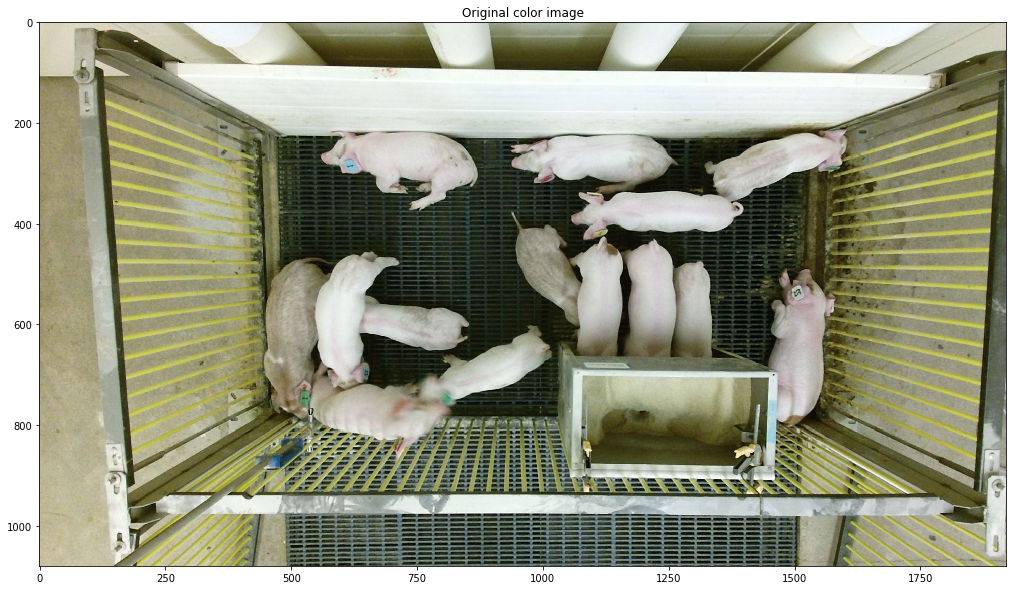

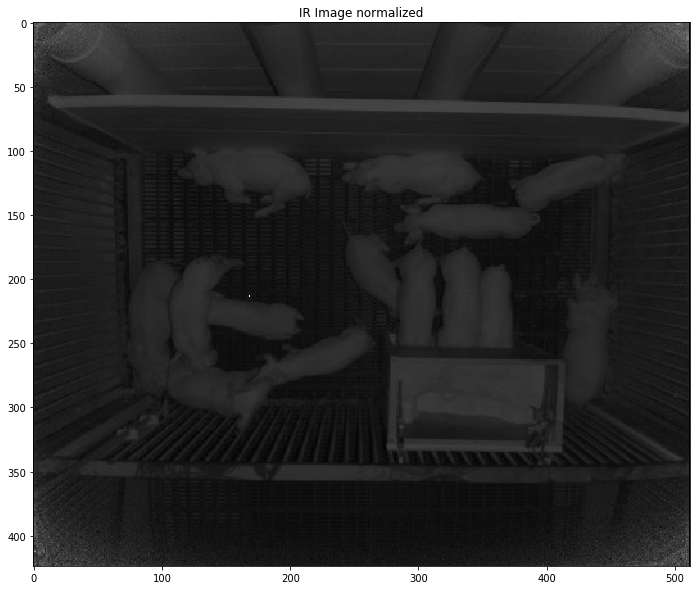

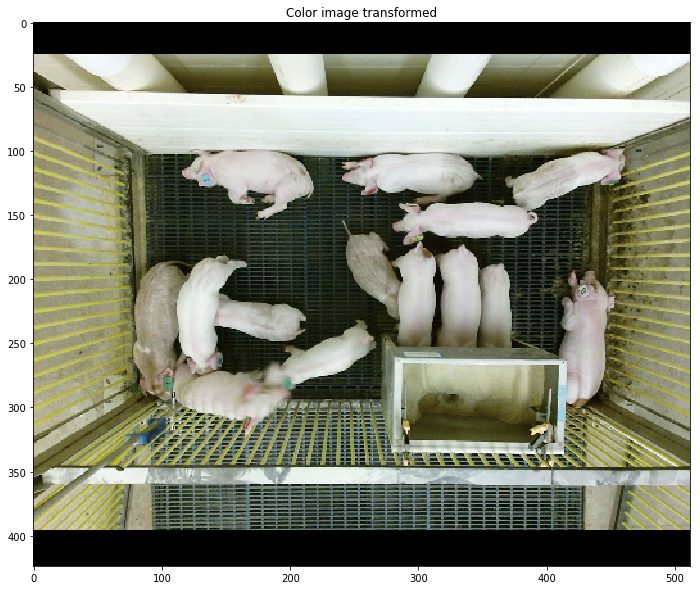

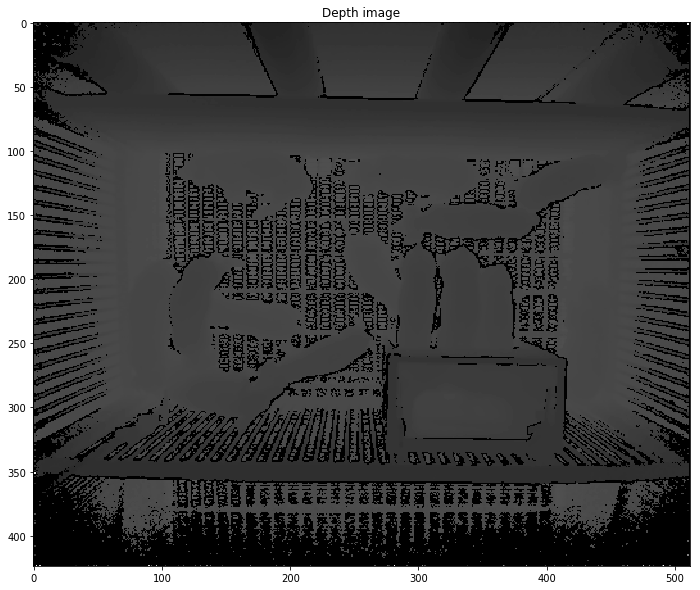

In [68]:
conn = sqlite3.connect('E:/Captures/2017_03_07_17_16_25/Files.sqlite')

c = conn.execute('SELECT * FROM generalFiles ORDER BY RANDOM()')
finfo = c.fetchone()[0]
finfo = finfo.replace('\\', '/')

fpath_depth = os.path.join('E:/Captures/2017_03_07_17_16_25','Depth', finfo + '.png')
fpath_color = os.path.join('E:/Captures/2017_03_07_17_16_25','Color', finfo + '.jpg')
fpath_ir = os.path.join('E:/Captures/2017_03_07_17_16_25','Infrared', finfo + '.jpg')


img_ir = np.array(Image.open(fpath_ir), dtype=np.float32)
img_col = np.array(Image.open(fpath_color), dtype=np.float32)
imgd = np.array(Image.open(fpath_depth), dtype=np.float32)

img = TransformCameraOnZPlane(img_col, img_ir, K_Color, K_IR, 2500.0, cam_shift=[26,-35,0])
img_col_trans = img

img_ir = (img_ir-img_ir.min())/(img_ir.max()-img_ir.min())



conn.close()



plt.figure(figsize=(20,10))
plt.imshow(img_col.astype(np.uint8))
plt.title('Original color image')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(img_ir, cmap='gray')
plt.title('IR Image normalized')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(img.astype(np.uint8))
plt.title('Color image transformed')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(imgd, cmap='gray')
plt.title('Depth image')
plt.show()



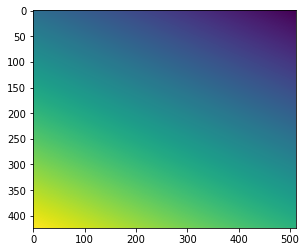

In [7]:
# HERE WE ARE CALCULATING THE FLOOR PLANE

# USe lease squares to extrapolate the floor plan
def get_floor_plane(floor, imgd):
    A = np.concatenate([floor, np.ones((floor.shape[0],1))], 1)
    b = np.array([ imgd[floor[i][1],floor[i][0]] for i in range(0, floor.shape[0])])
    X = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(A), A)), np.transpose(A)), b)
    floorplane = np.copy(imgd)*0
    P = np.zeros(( floorplane.shape[0]*floorplane.shape[1] ,3))
    i=0
    for x in range(0, floorplane.shape[1]):
        for y in range(0, floorplane.shape[0]):
            P[i,:] = [ x,y,1 ]
            i+=1
    P_out = np.dot( P, X )
    i=0
    for x in range(0, floorplane.shape[1]):
        for y in range(0, floorplane.shape[0]):
            floorplane[y,x] = P_out[i]
            i+=1
    return floorplane, X

if 0:
    floor = np.array([ [188,169],[172,243], [87,281],[82,226],[88,108],  [434,108], [442,191]  ,[357,155]  ])
    floorplane, _ = get_floor_plane(floor, imgd)
    with open('floorplane.pickle', 'wb') as file:
        print('Saving the floor plane')
        pickle.dump(floorplane, file)
        
    plt.figure(figsize=(20,10))
    plt.imshow(floorplane-imgd)
    plt.plot( floor[:,0], floor[:,1] )
    for i in range(0, floor.shape[0]):
        plt.text( floor[i,0], floor[i,1], imgd[floor[i][1],floor[i][0]] , color='magenta')
    plt.show()

with open('floorplane.pickle', 'rb') as file:
    floorplane = pickle.load(file)
        

plt.imshow(floorplane)
plt.show()




[[ 0.012237   -0.20977711]
 [-0.20977711  3.59617906]]
[[ 1.1933835  -1.75073294]
 [-1.75073294  2.56838294]]
[[0.72889149 1.05925238]
 [1.05925238 1.53934518]]
[[ 0.24626621 -0.40698732  0.11406014]
 [-0.40698732  0.6726001  -0.18849939]
 [ 0.11406014 -0.18849939  0.05282785]]
[[ 1.89139556e+00 -2.61380359e+00 -6.56734570e-02]
 [-2.61380359e+00  3.61213135e+00  9.07570690e-02]
 [-6.56734570e-02  9.07570690e-02  2.28032837e-03]]
[[0.29319285 0.06262372]
 [0.06262372 0.01337594]]
[[3.82522412 0.5831737 ]
 [0.5831737  0.08890762]]
[[1.96868605 1.879538  ]
 [1.879538   1.79442685]]
[[ 1.45079941 -1.85295083]
 [-1.85295083  2.3665758 ]]
[[ 2.49824901 -0.68134064]
 [-0.68134064  0.18582017]]
[[0.12291945 0.63120798]
 [0.63120798 3.24133829]]
[[ 2.41088597 -1.48998961  0.3104145 ]
 [-1.48998961  0.92085195 -0.19184416]
 [ 0.3104145  -0.19184416  0.03996753]]
[[3.16137854 1.43457514]
 [1.43457514 0.65098368]]
[[ 0.45906891  1.14552708 -0.86236309]
 [ 1.14552708  2.85846478 -2.15187798]
 [-0.8

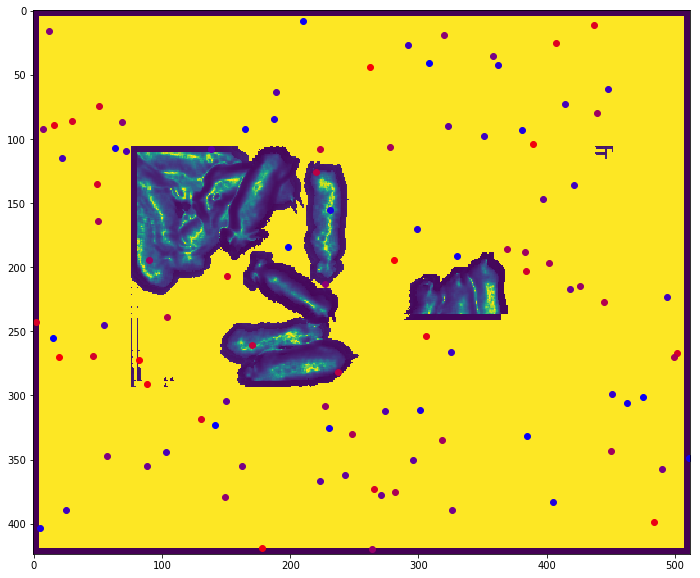

1.0
0.0


In [11]:


def myclust(img, N):
    
    P = np.concatenate([ np.random.uniform(0, img.shape[1], (N,1)), np.random.uniform(0, img.shape[0], (N,1)) ],axis=1).astype(np.int32)
    V = np.random.uniform(0,1,(N,2))
    L = np.random.uniform(0,N, (N,)).astype(np.int32)
    
    # Get the population and calculate some properties
    for l in np.unique(L):
        idx = np.where(L==l)[0]
        if len(idx) > 1:
            pop = P[idx,]
            popn = (pop-np.mean(pop, keepdims=True))/np.std(pop, keepdims=True)
            popcor = np.cov(popn)
            print(popcor)
    
#    clear_output()
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    for i in range(0,N):
        plt.plot( P[i,0], P[i,1], 'ro' , color=[L[i]/N,0,1-L[i]/N])
    plt.show()

    print(np.max(img))
    print(np.min(img))

myclust(normals[:,:,2], 100)

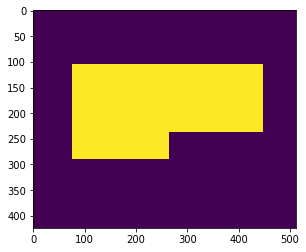

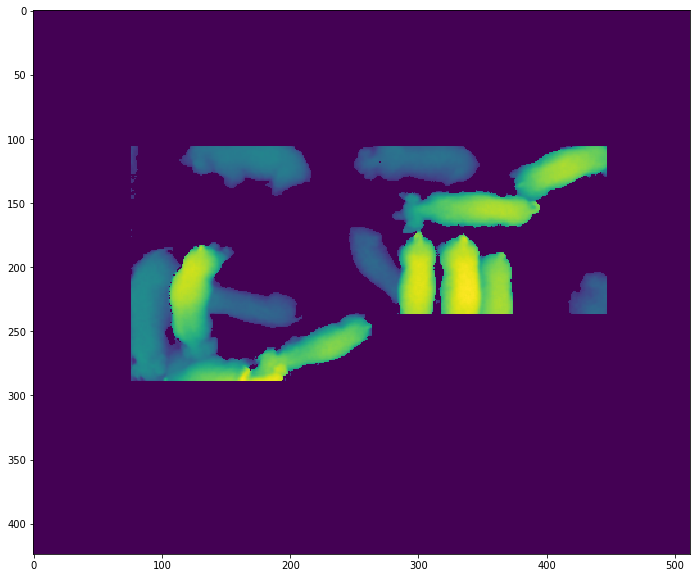

370.23975
0.0


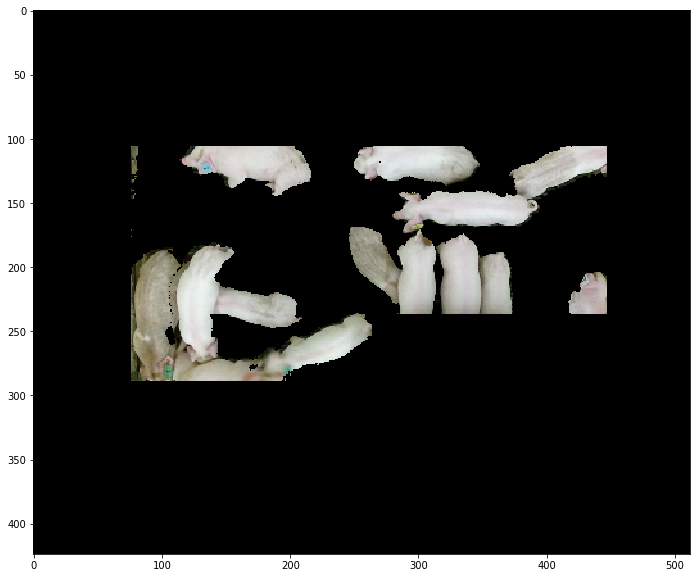

370.23975
0.0


In [69]:
ir_mask = np.array(Image.open('ir_mask.png'))>0
plt.imshow(ir_mask)
plt.show()

pigheights = floorplane-imgd


img = np.multiply( pigheights, pigheights<600 )
img = np.multiply(img, pigheights>50)
img = np.multiply(img, ir_mask)

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

print(np.max(img))
print(np.min(img))


plt.figure(figsize=(20,10))
plt.imshow(np.multiply(img_col_trans, np.stack([img>0]*3, 2)  ).astype(np.uint8))
plt.show()

print(np.max(img))
print(np.min(img))

In [ ]:
def watershed(img):
    img = img.astype(np.uint8)
    ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    plt.figure(figsize=(20,10))
    plt.imshow(unknown)
    plt.show()
    
watershed(img)



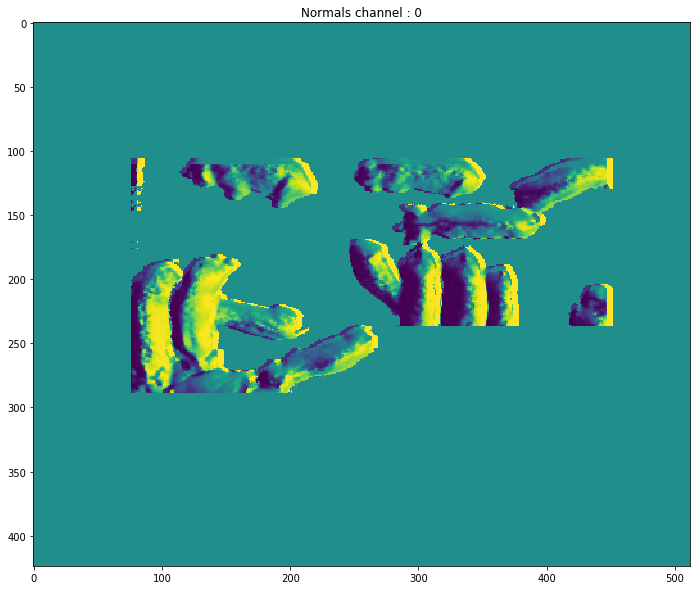

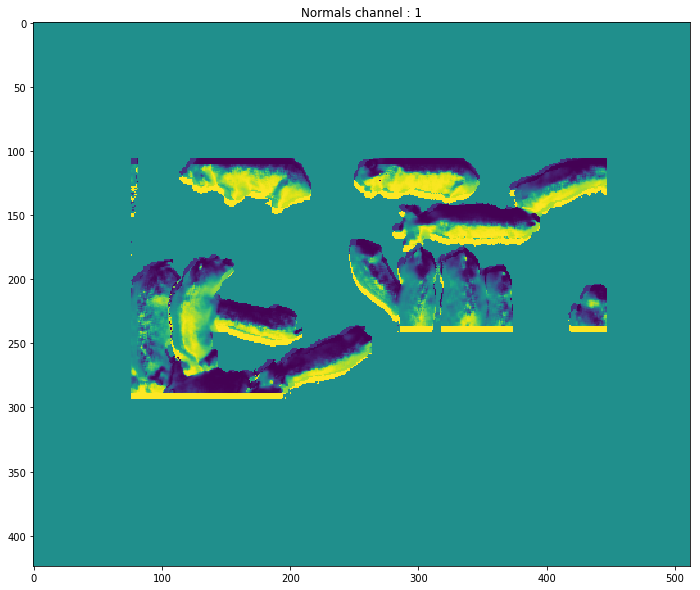

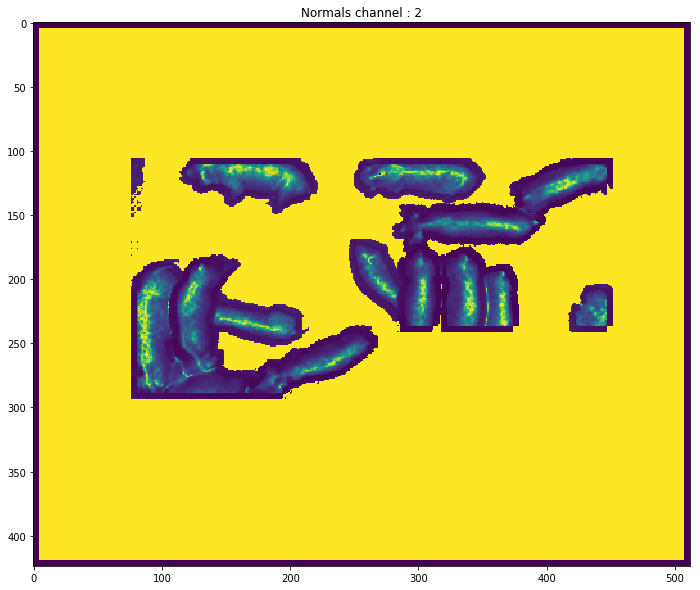

In [70]:
# Let's try to calculate the normals

normals = np.zeros(( img.shape[0], img.shape[1], 3 ))

r = 5
for x in range(r, img.shape[1]-r):
    for y in range(r,img.shape[0]-r):
        a = np.array([ x-r, y, img[y,x-r] ])
        b = np.array([ x, y-r, img[y-r,x] ])
        c = np.array([ x, y, img[y,x] ])
        z = np.cross( a-c, b-c )
        z = np.divide(z, np.linalg.norm(z))
        normals[y,x,:] = z

        
for i in range(0,3):        
    plt.figure(figsize=(20,10))
    plt.imshow(normals[:,:,i])
    plt.title('Normals channel : {}'.format(i))
    plt.show()

In [ ]:
# MORPHOLOGY?

kernel = np.ones((5,5),np.uint8)
gradient = cv2.morphologyEx( (normals[:,:,2]>0.2).astype(np.float32), cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(20,10))
plt.imshow(gradient)
plt.show()

print(np.max(gradient))

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(normals[:,:,2]>0.2)
plt.show()

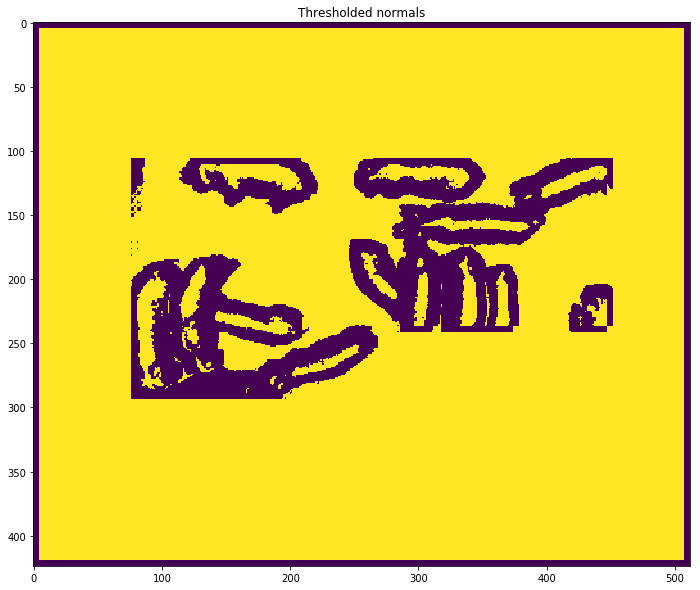

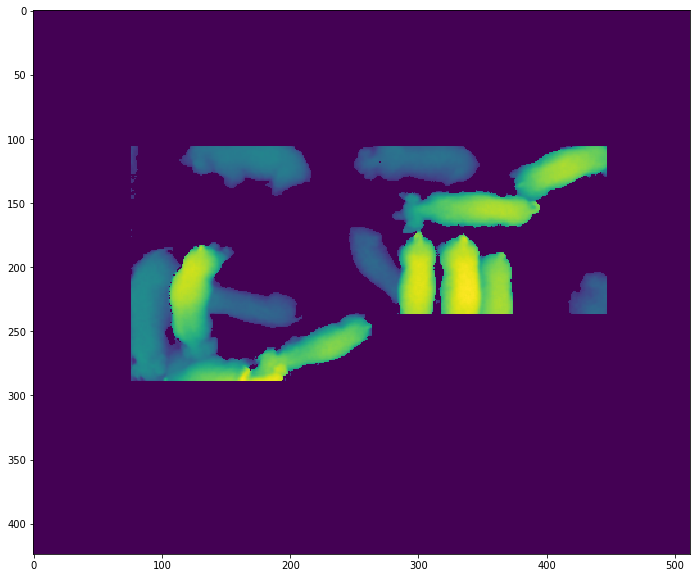

(424, 512)


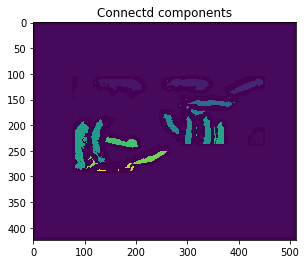

Perc: 0.14780181308962265
Perc: 0.8037800339033019
Perc: 0.005882407134433962
Perc: 0.00514537883254717
DOM 0.04965836253634647
DOM 0.013129421941052617
Perc: 4.145784198113207e-05
DOM 0.00018452527740015298
Perc: 1.842570754716981e-05
DOM 0.2619047619047619
Perc: 2.7638561320754718e-05
DOM 0.00023349604075235638
Perc: 9.212853773584905e-06
DOM 6.071138566148796e-05
Perc: 4.606426886792453e-06
Perc: 9.212853773584905e-06
DOM 3.636975309483826e-05
Perc: 4.606426886792453e-06
Perc: 1.842570754716981e-05
DOM 6.086890359887464e-05
DOM 0.0550030271087479
Perc: 5.5277122641509435e-05
DOM 0.00011114485785132687
Perc: 1.842570754716981e-05
DOM 0.0002291093893193369
Perc: 9.212853773584906e-05
DOM 0.00043371675269067797
Perc: 0.0007876989976415094
DOM 0.008698398625606103
DOM 0.08067470590806916
DOM 0.10302172303313063
DOM 0.05464312622301186
Perc: 0.004703161851415095
DOM 0.16724818533185057
Perc: 0.007425560141509434
DOM 0.11638479180259277
DOM 0.024951865121107964
Perc: 1.842570754716981e-05

c:\anaconda\envs\ml\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\anaconda\envs\ml\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
c:\anaconda\envs\ml\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
c:\anaconda\envs\ml\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


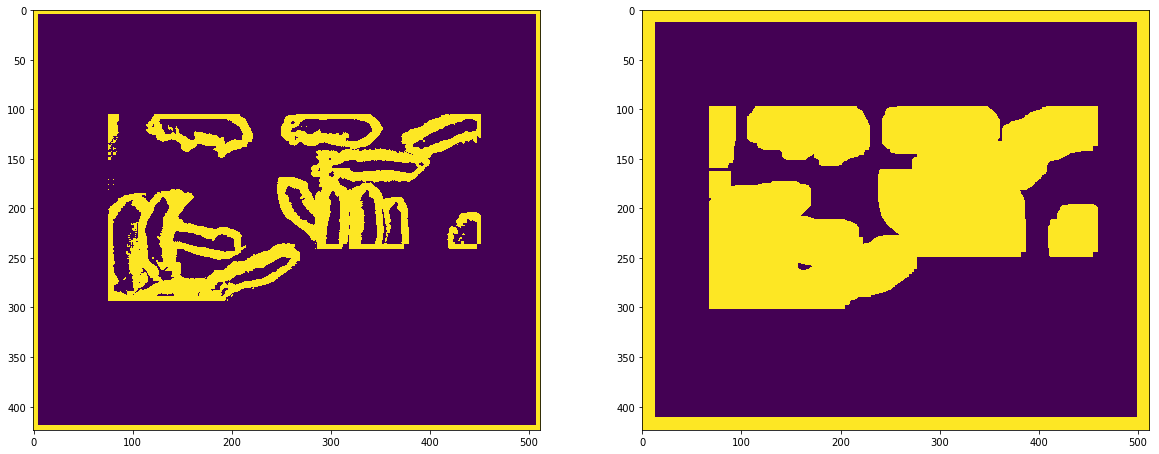

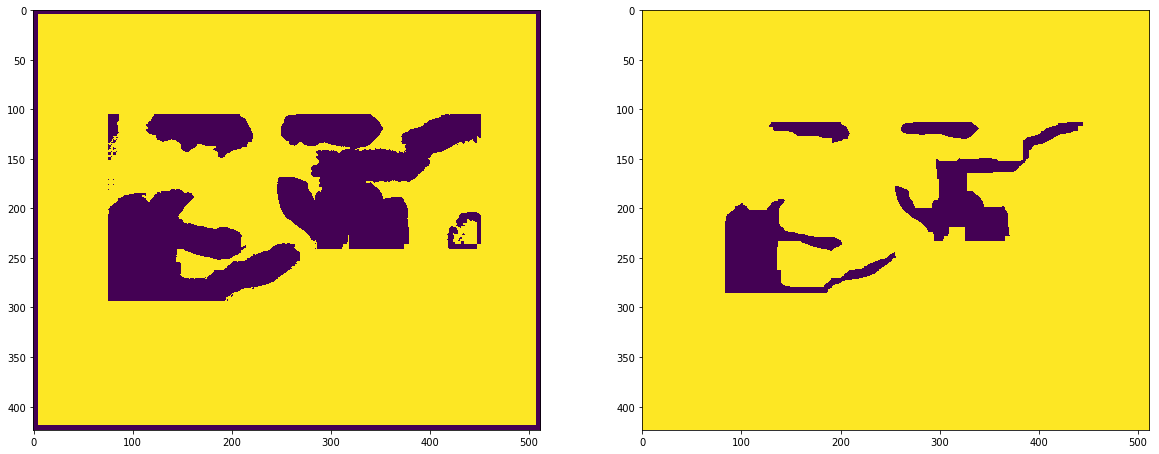

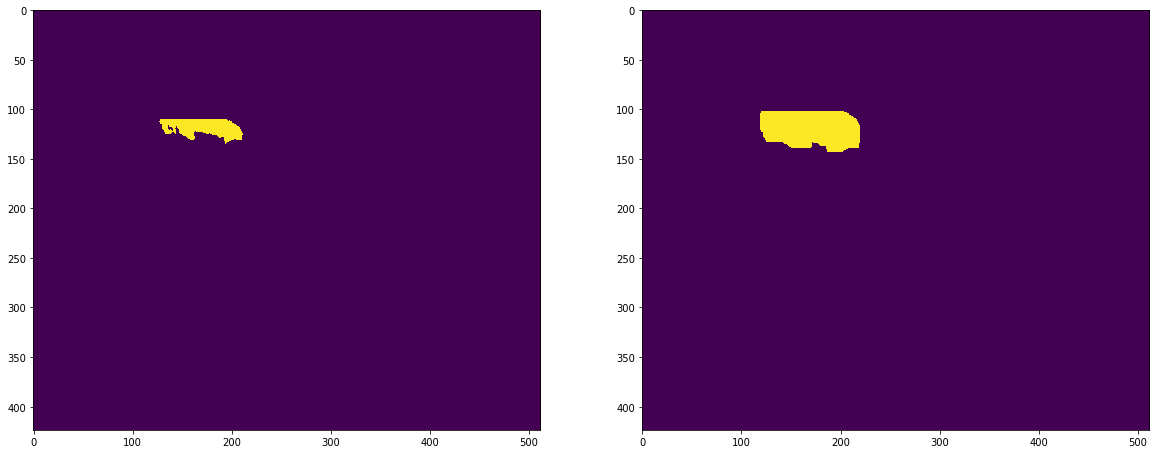

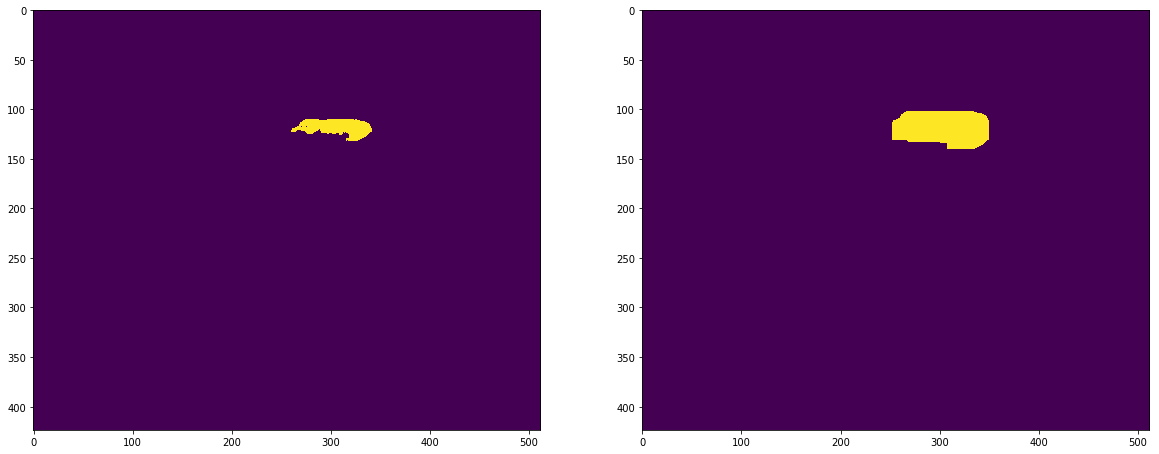

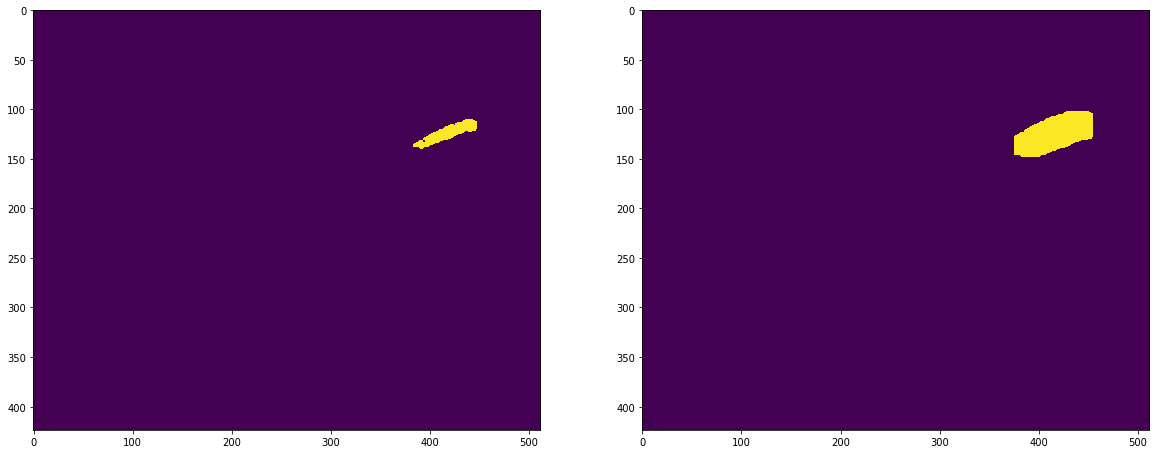

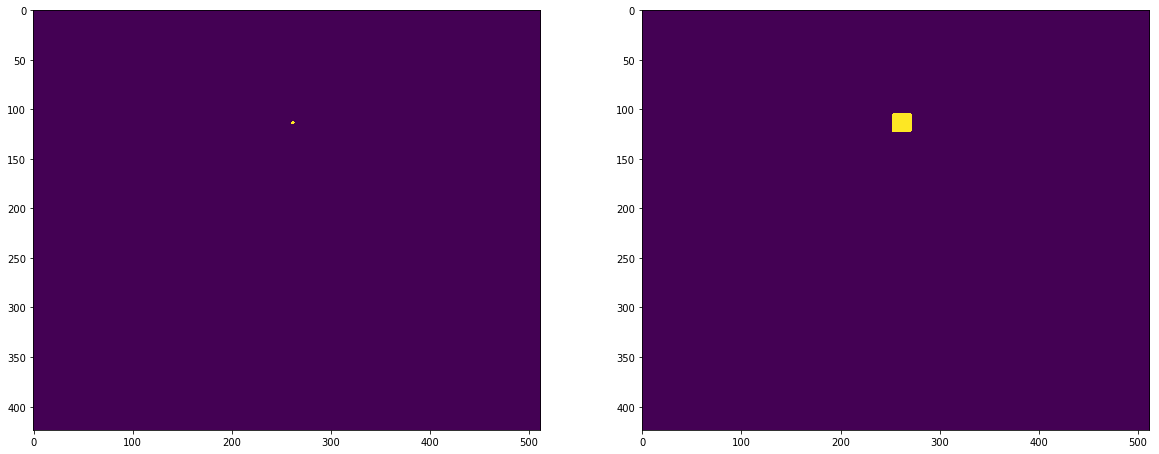

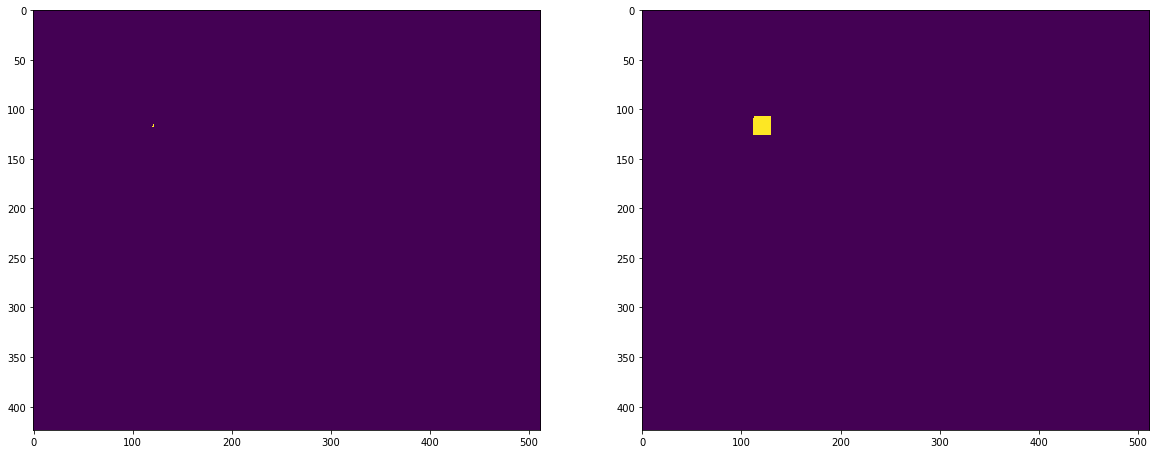

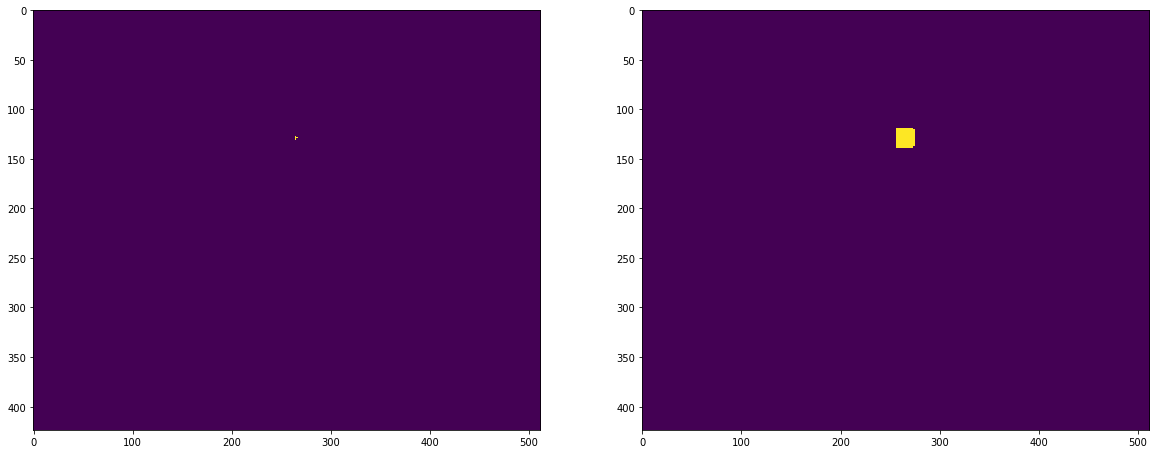

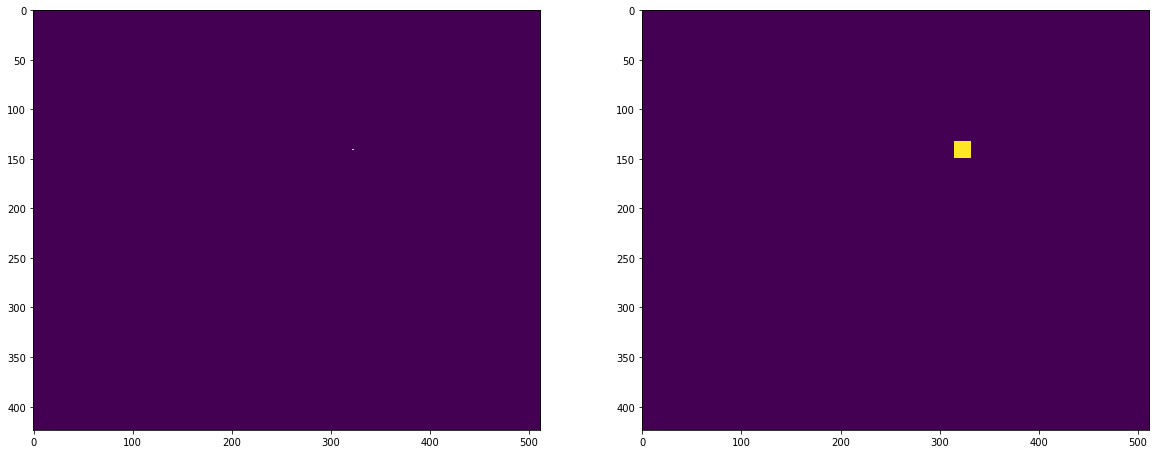

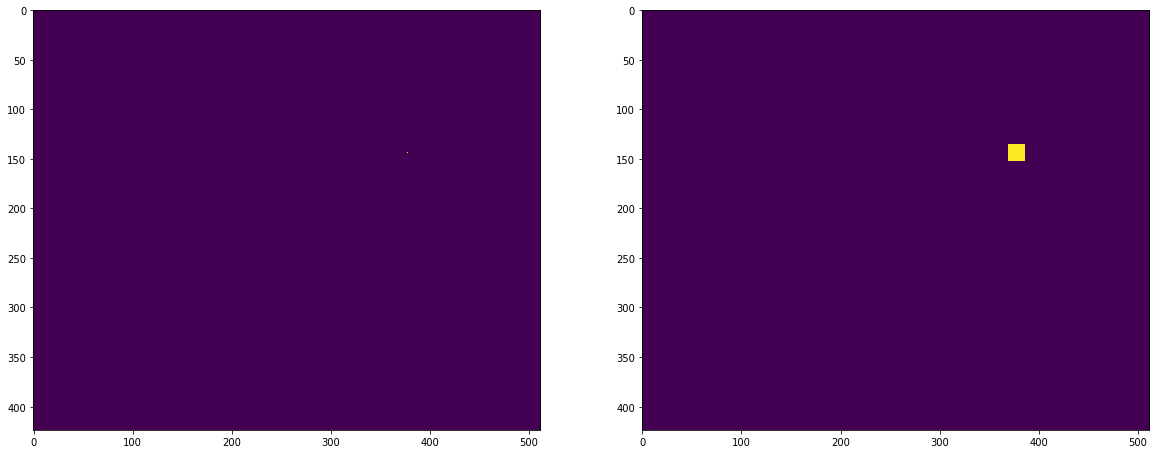

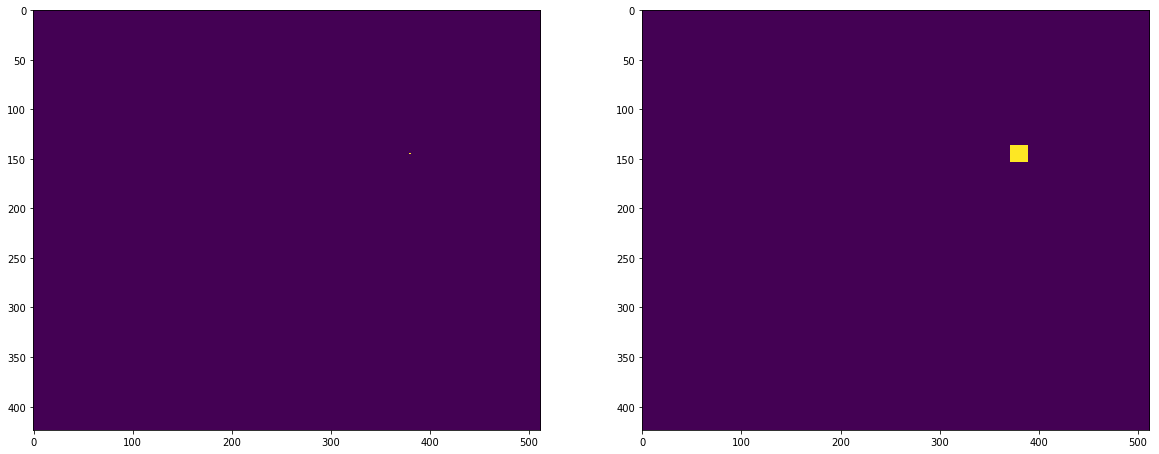

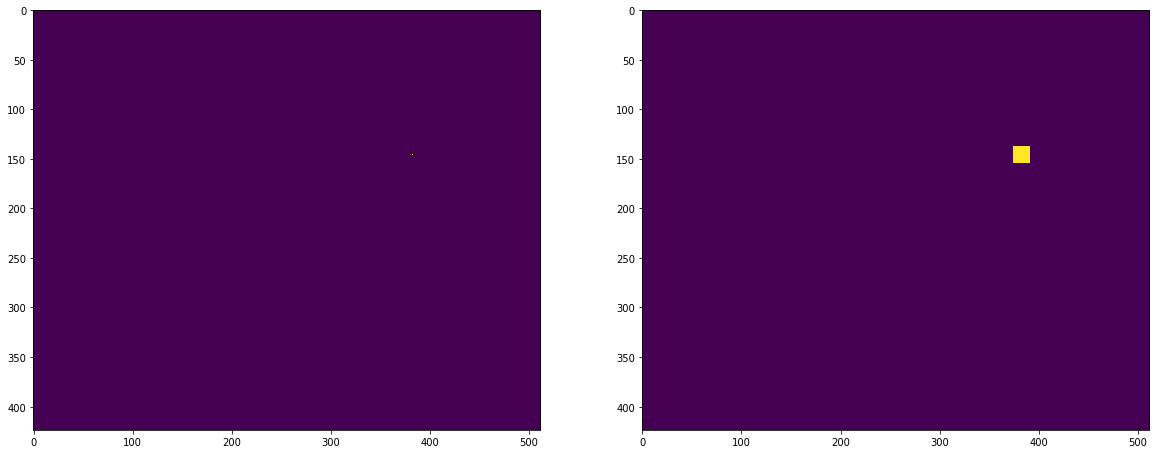

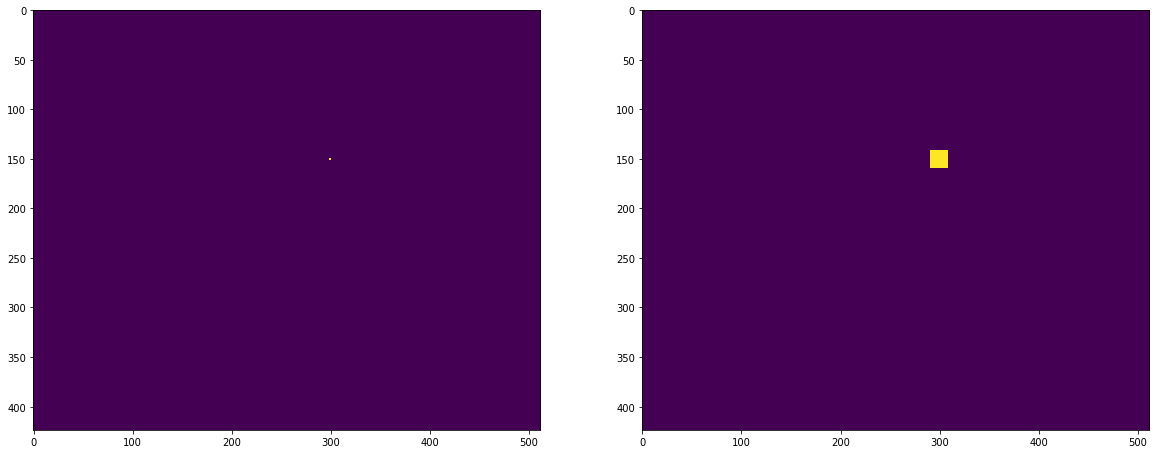

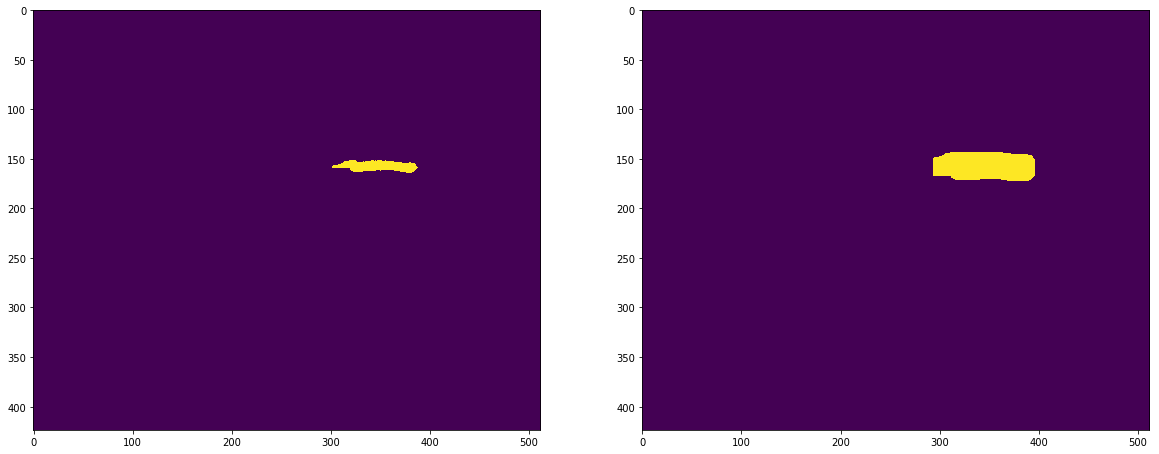

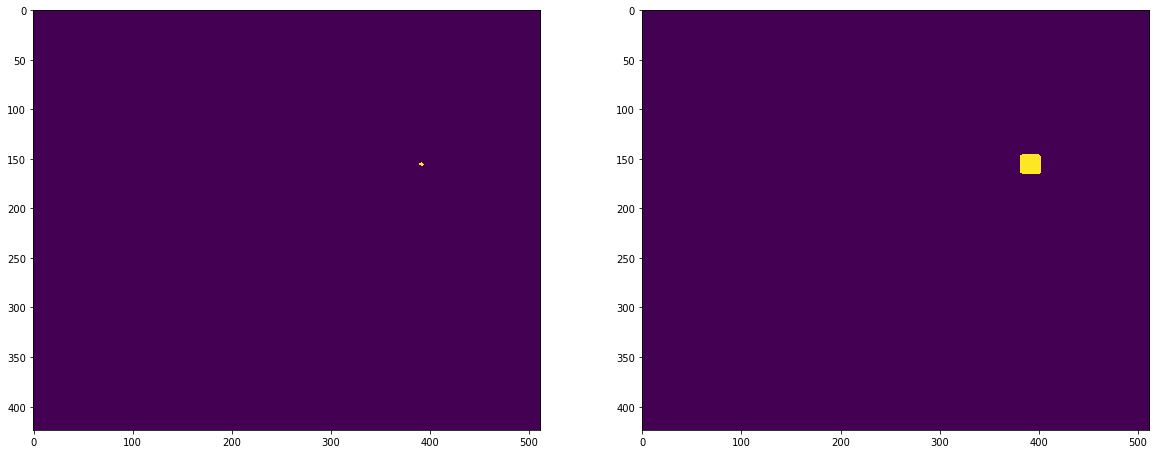

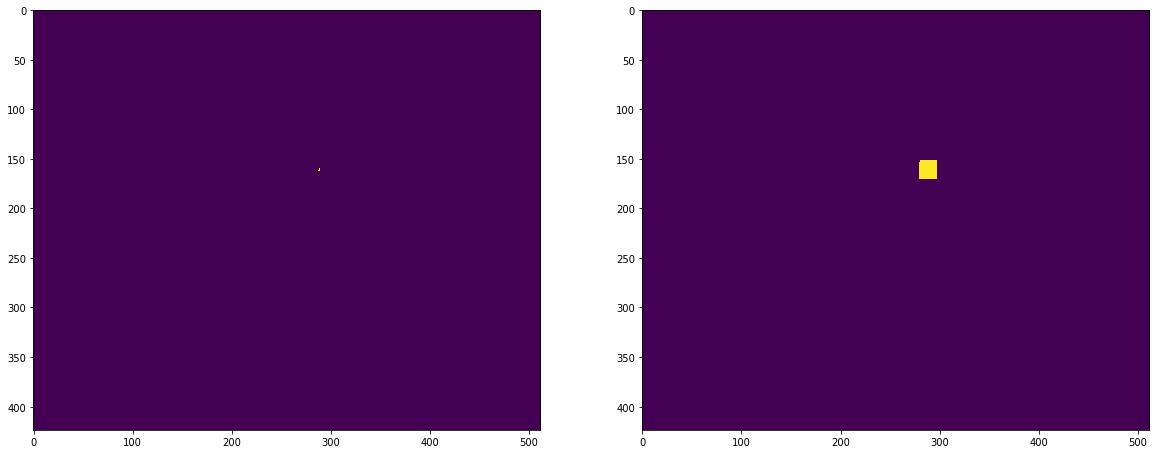

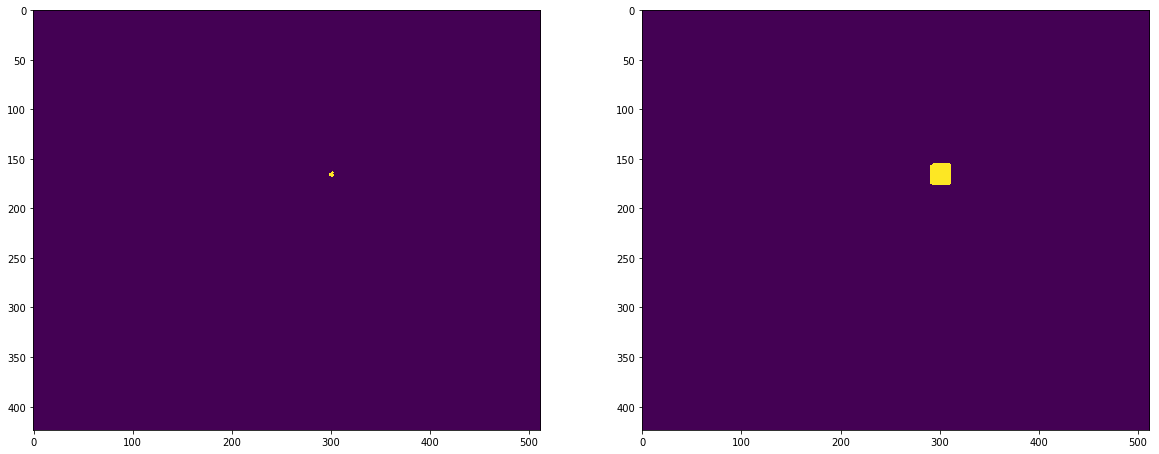

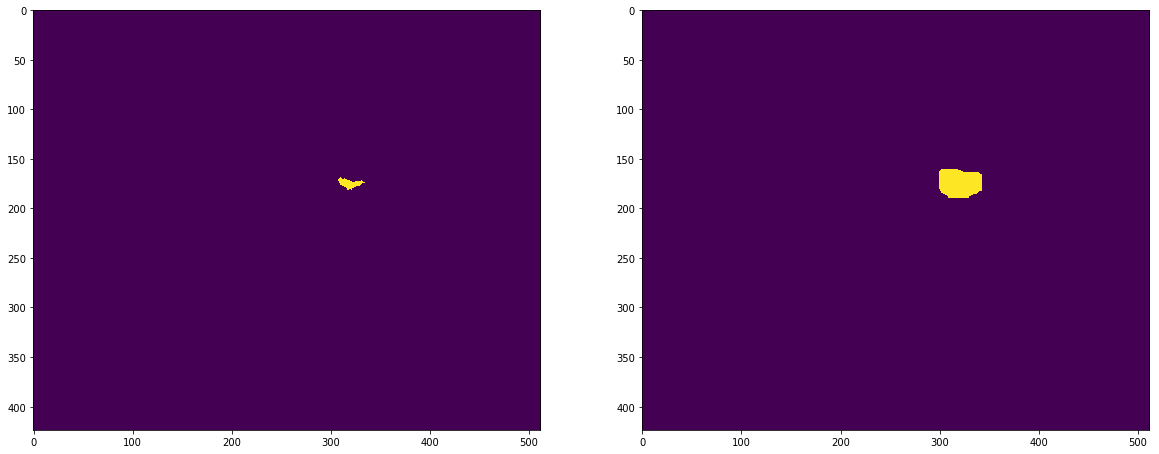

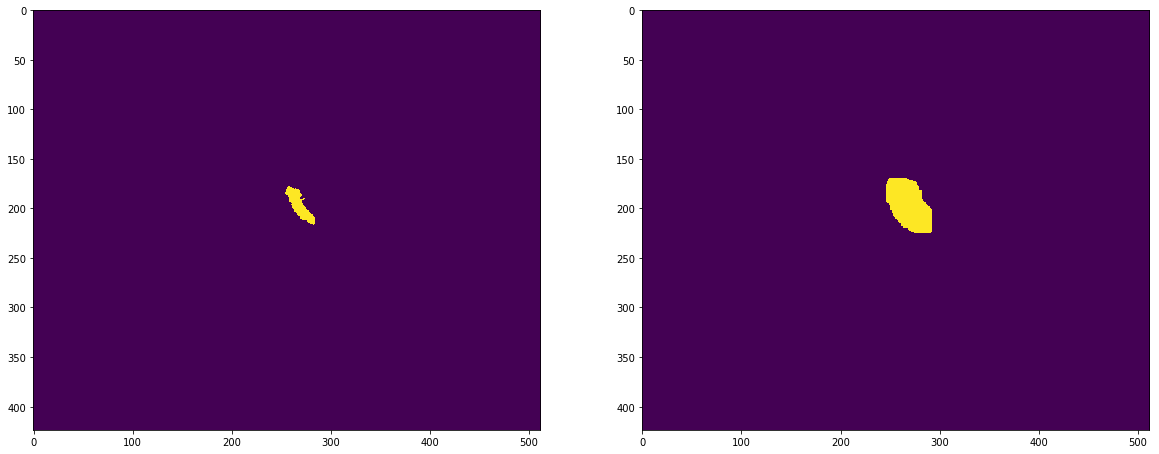

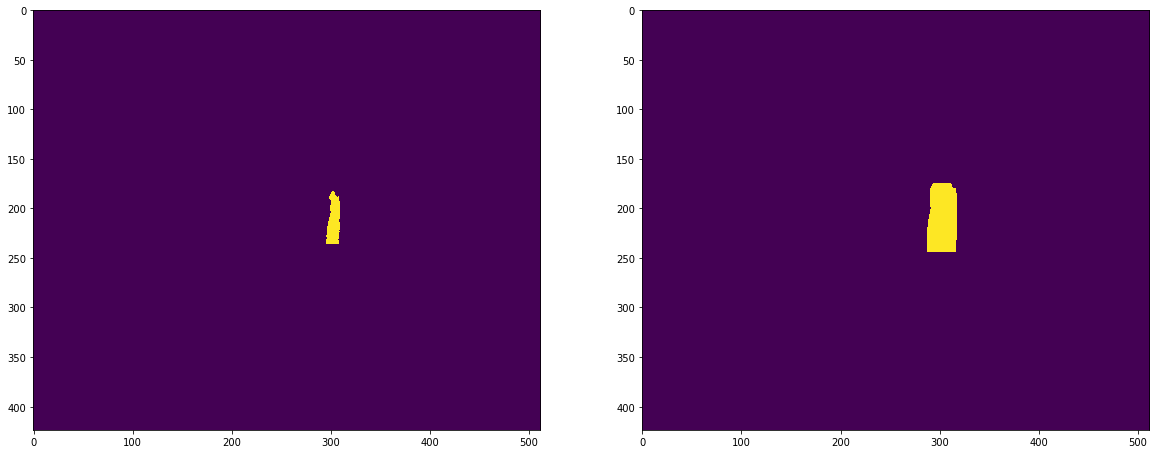

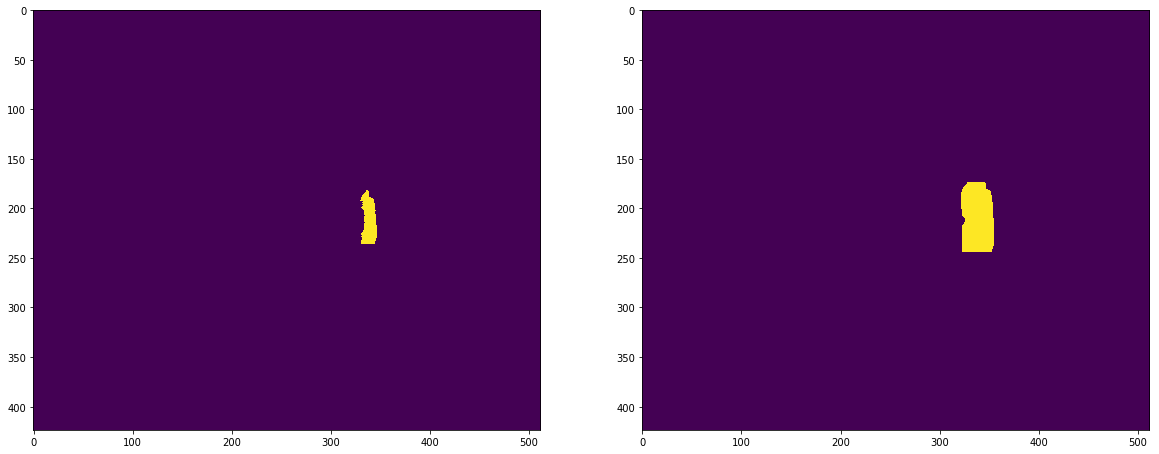

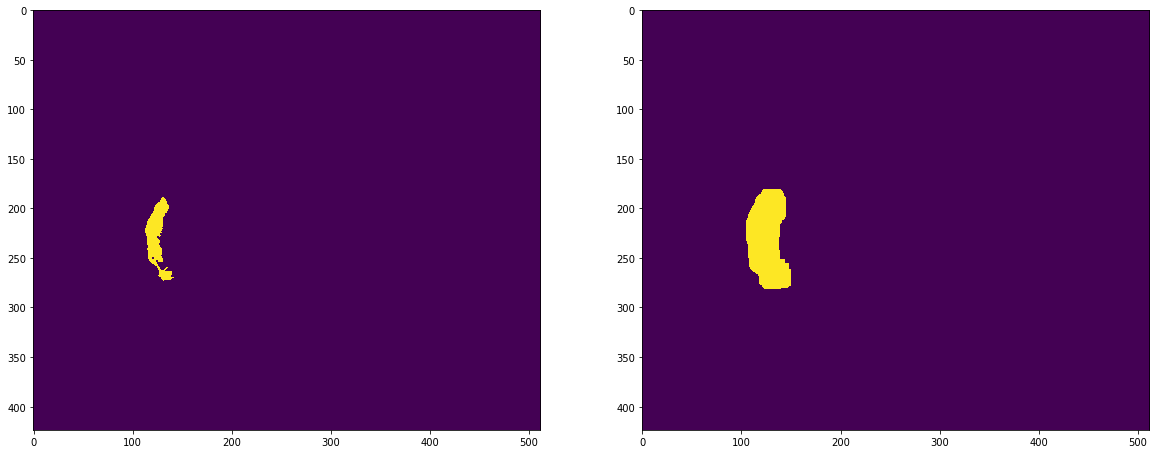

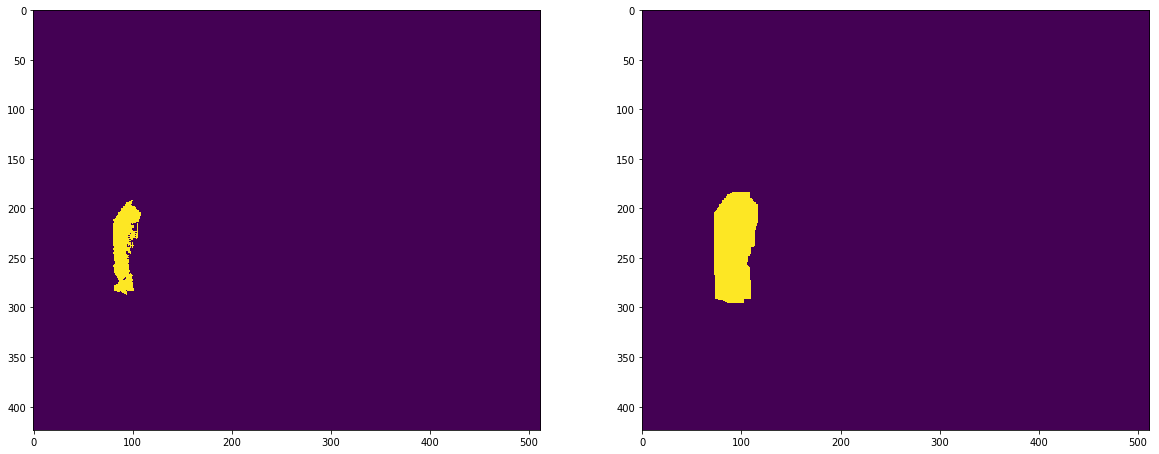

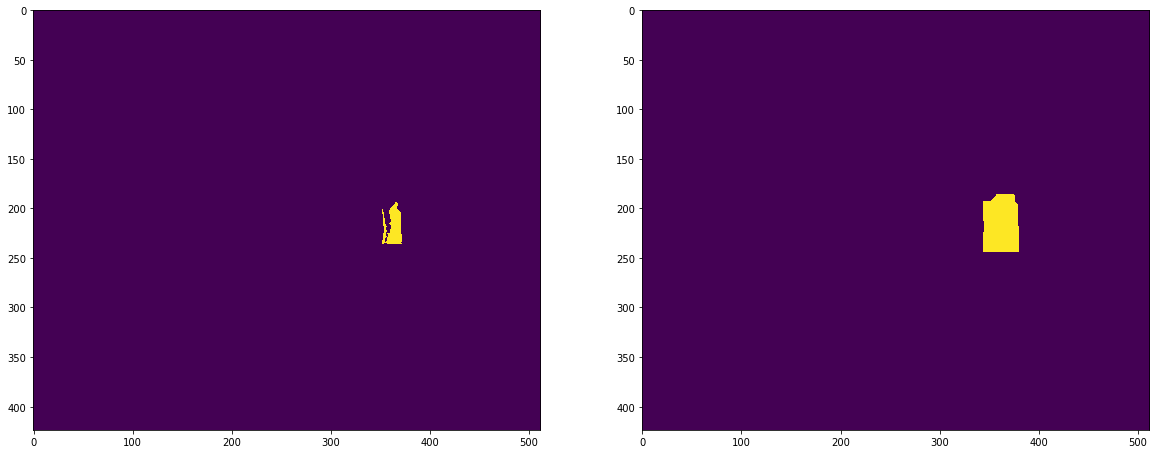

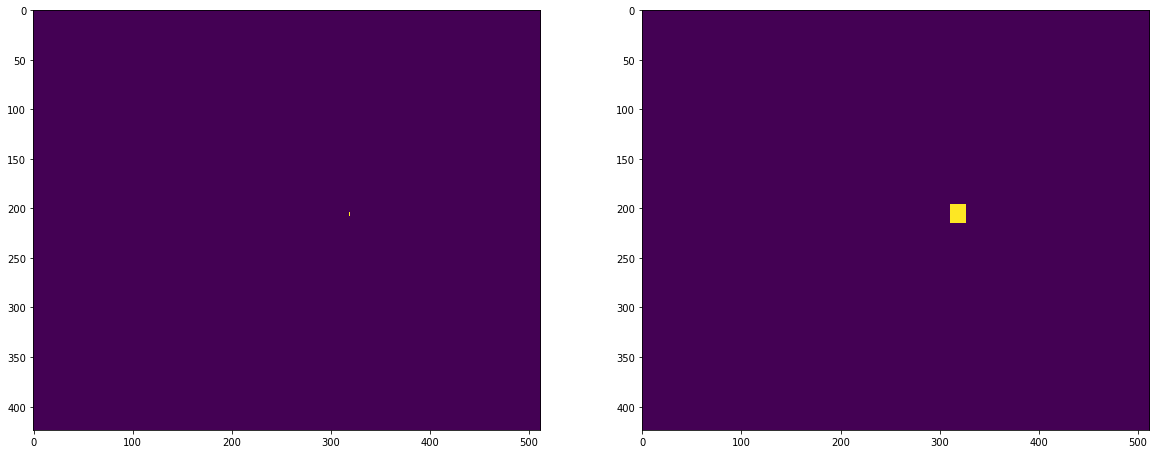

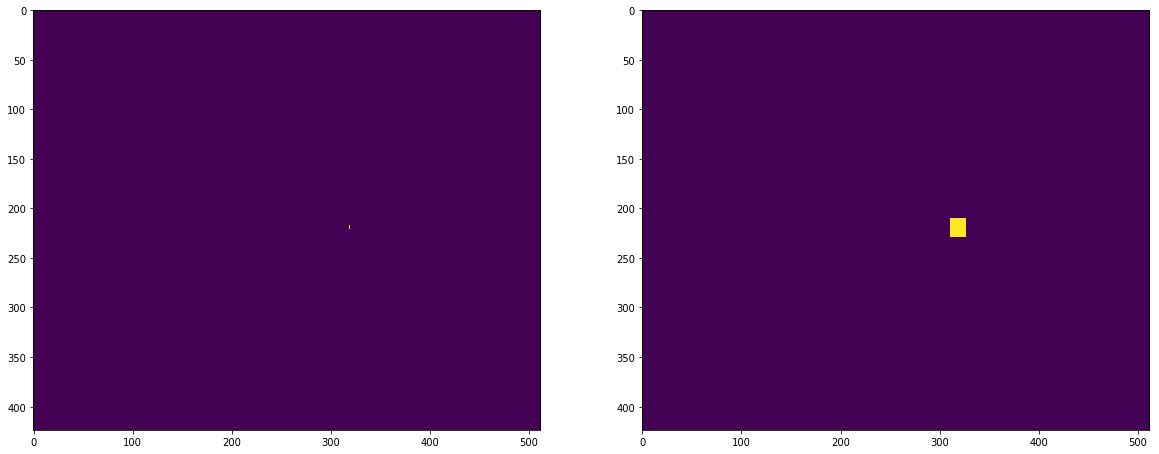

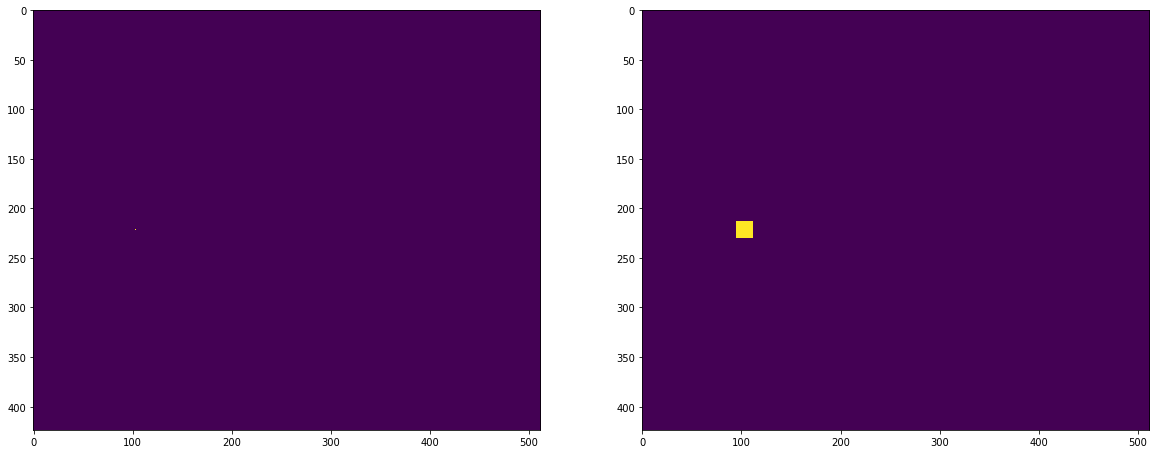

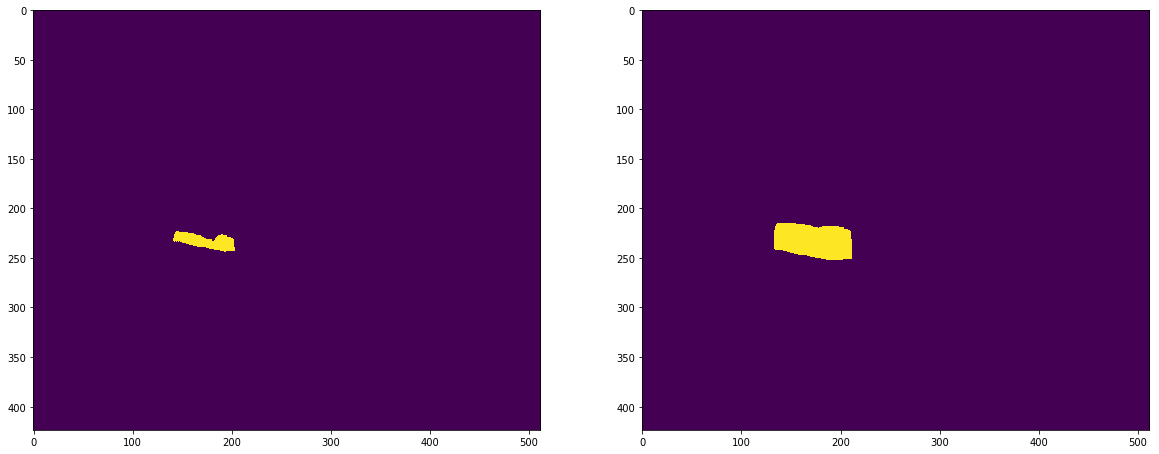

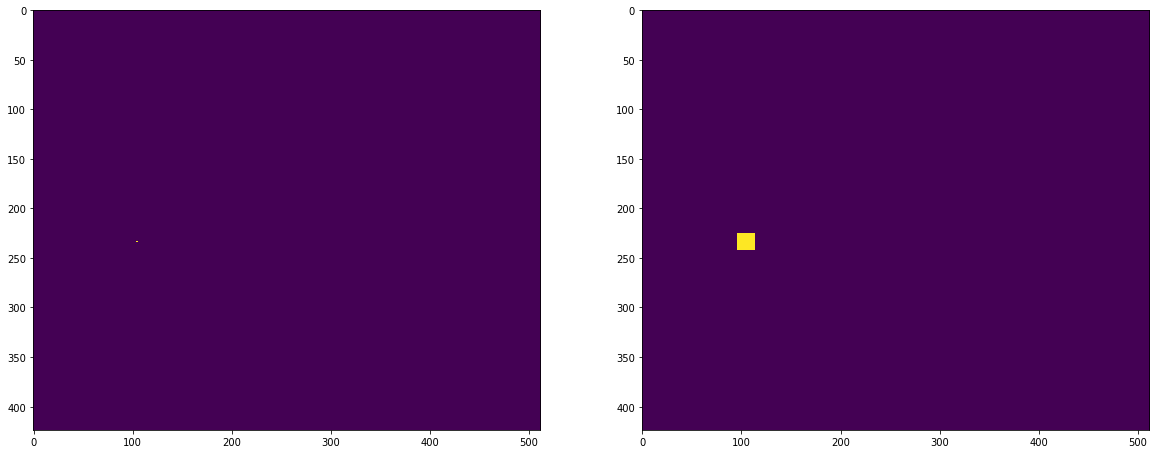

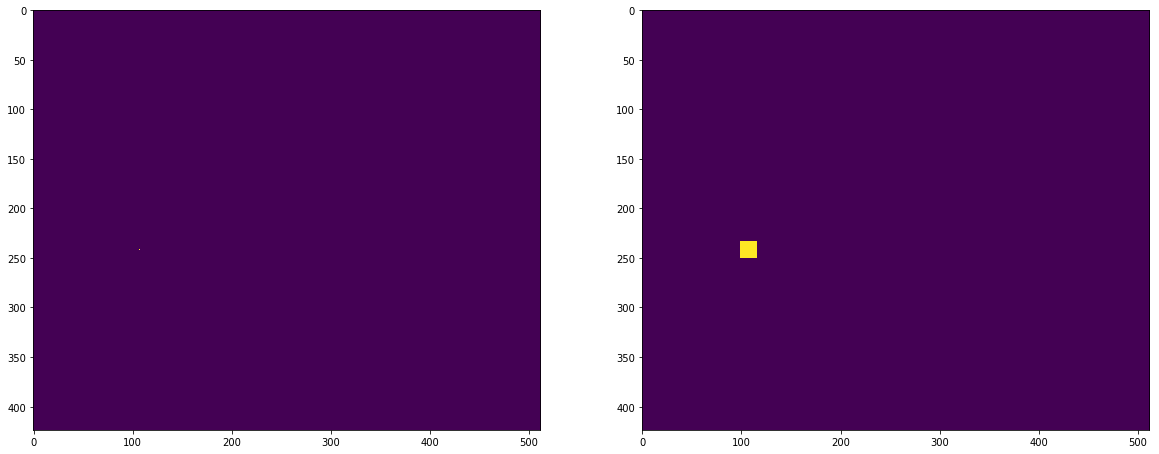

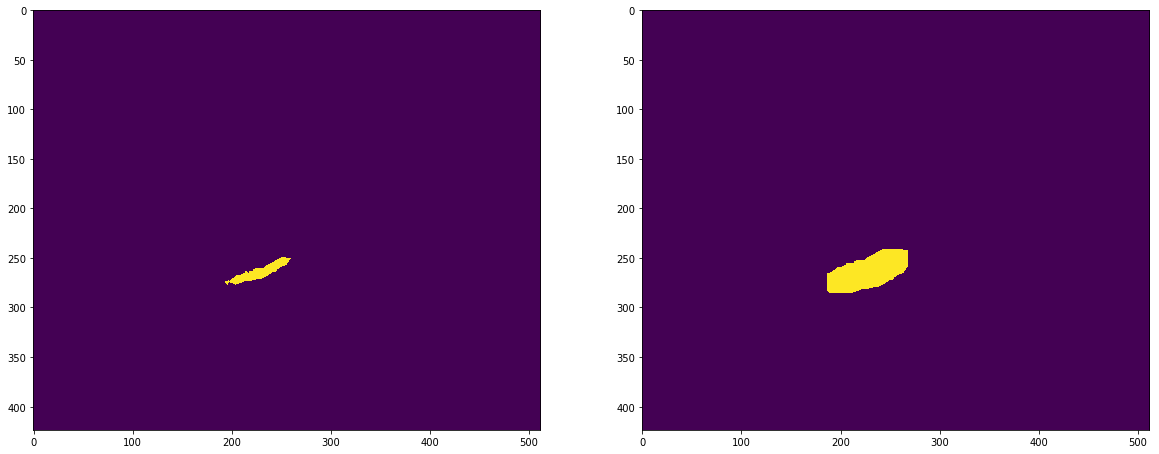

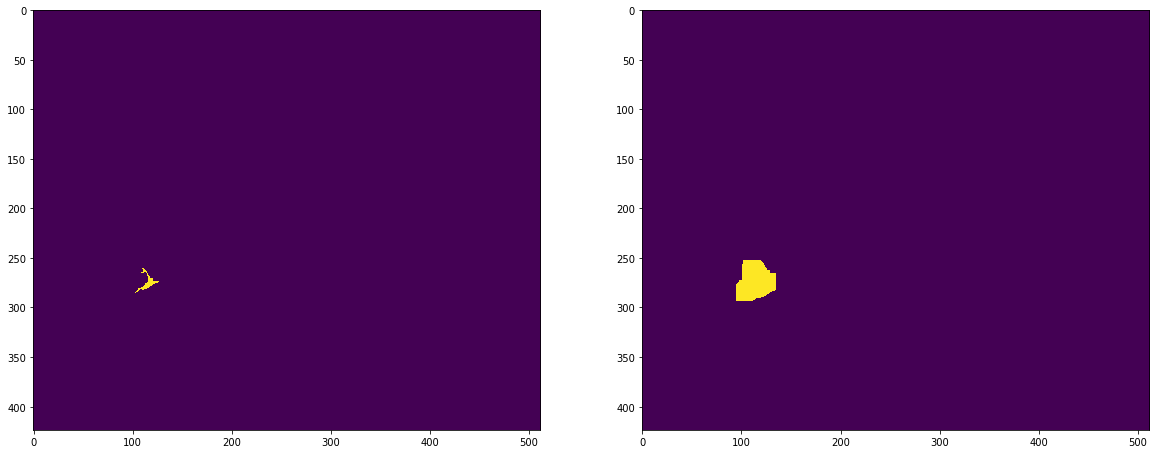

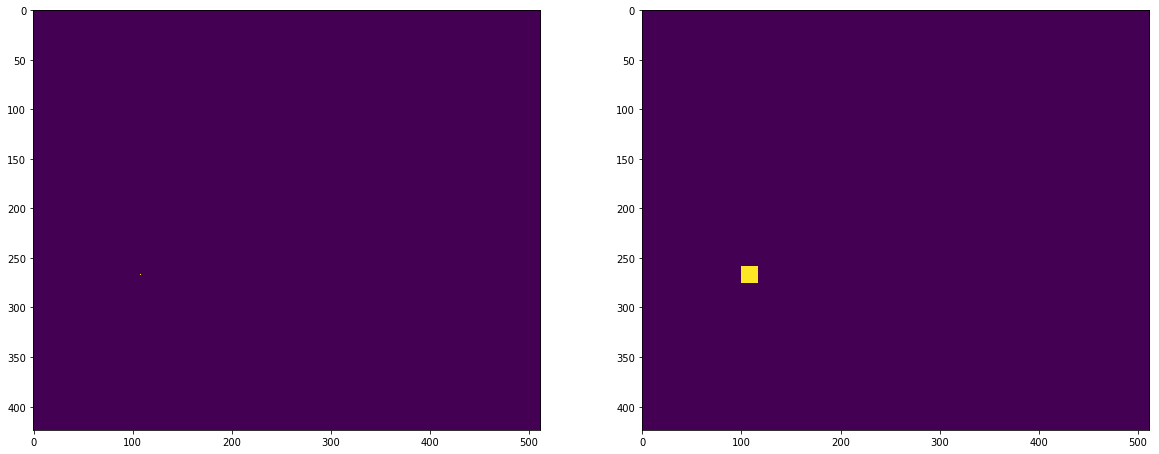

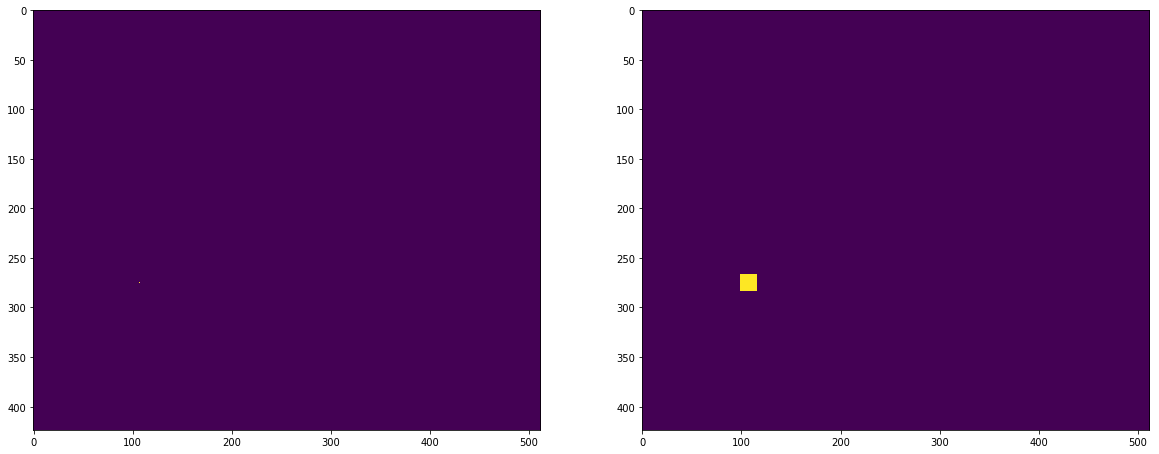

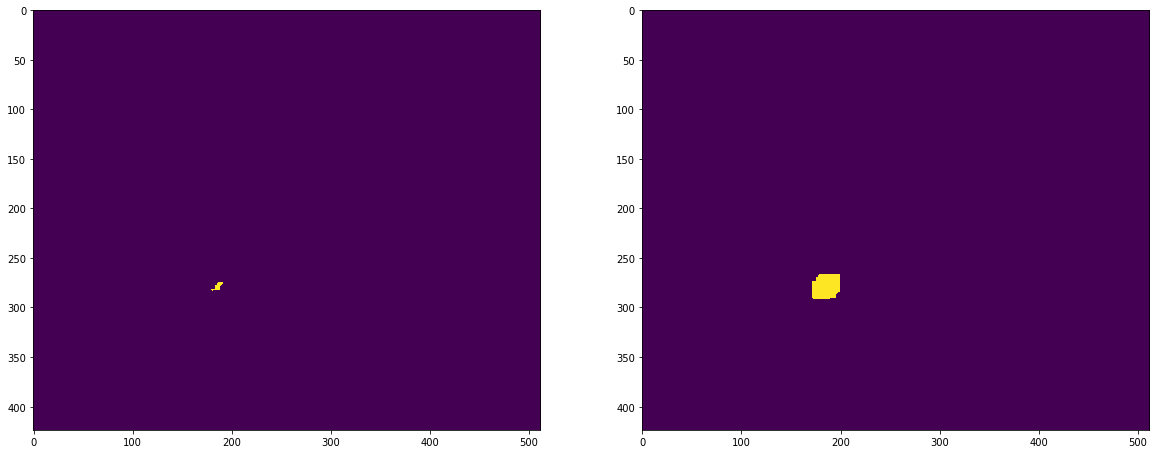

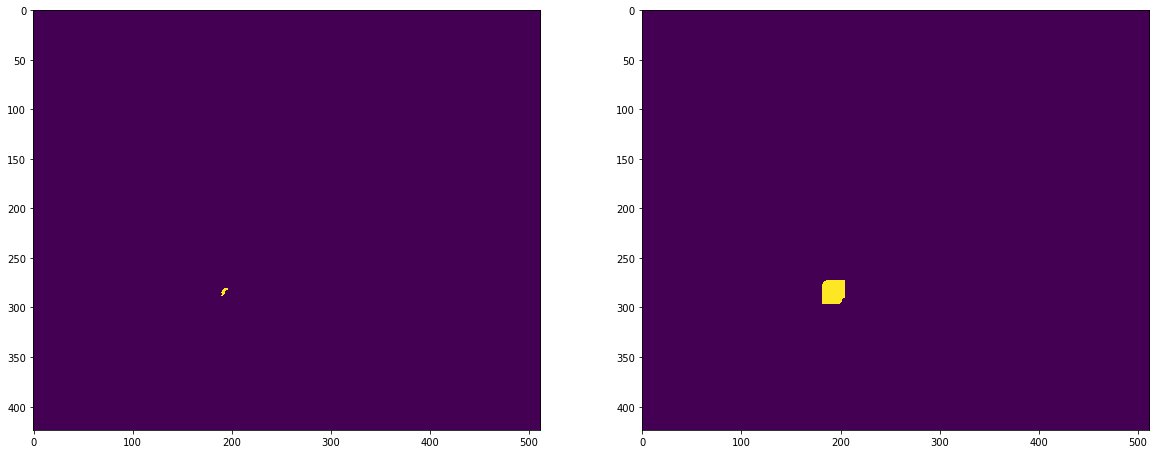

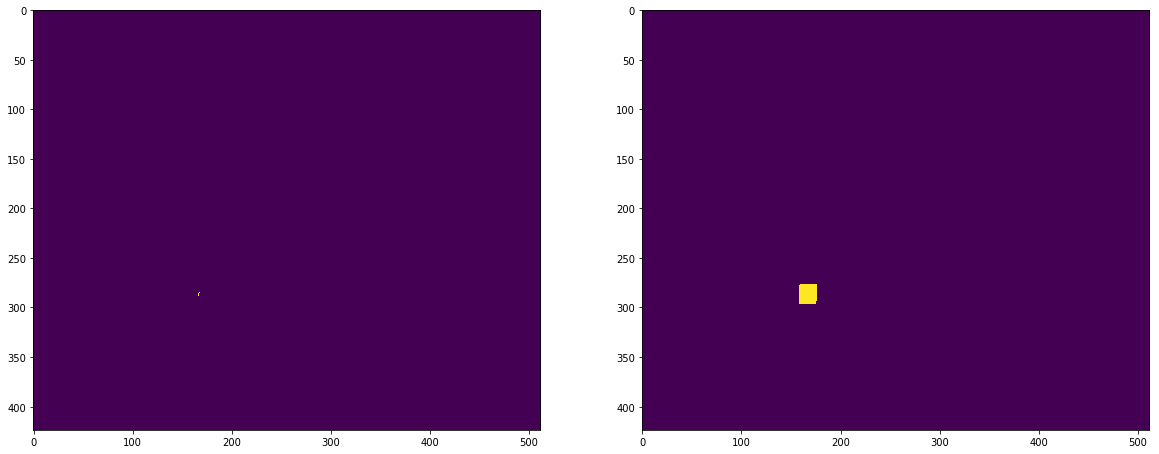

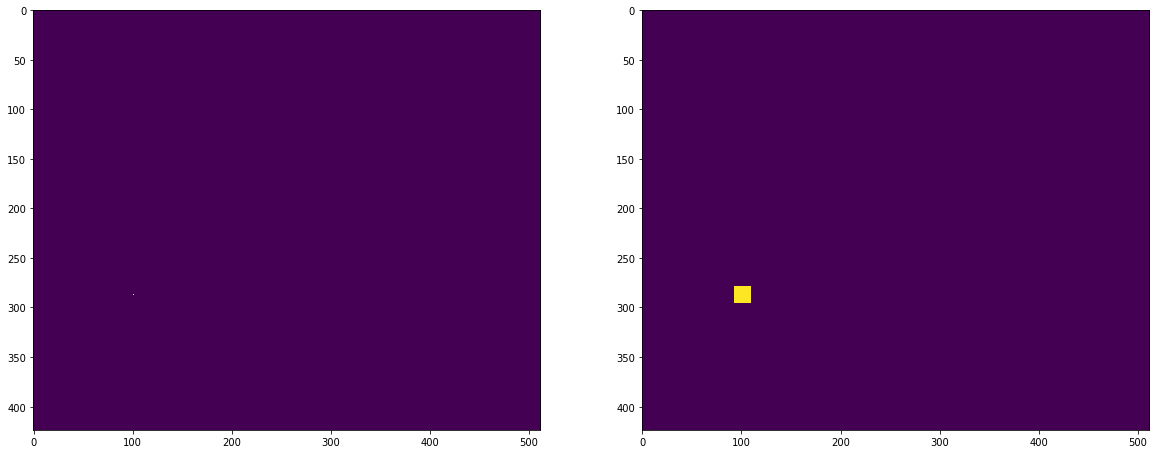

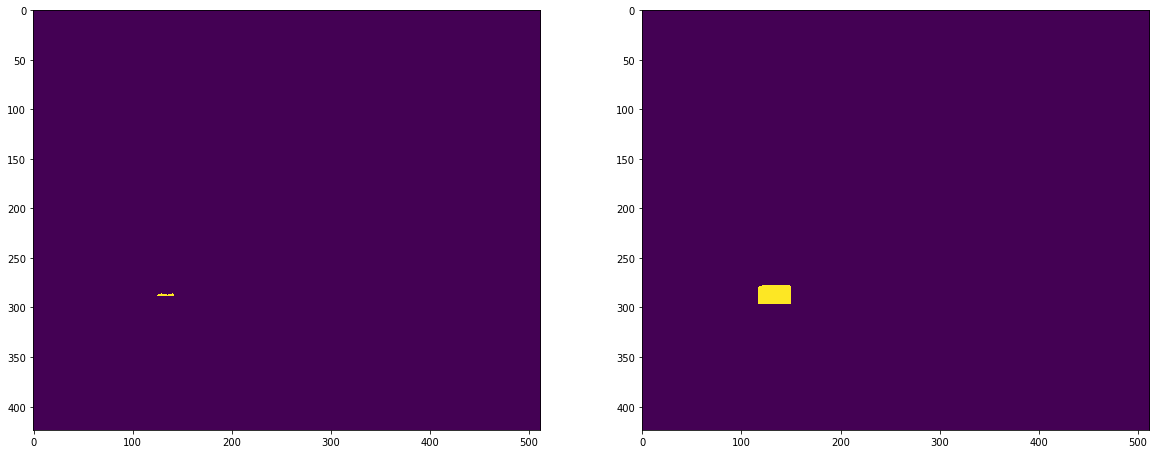

1.0
0.0


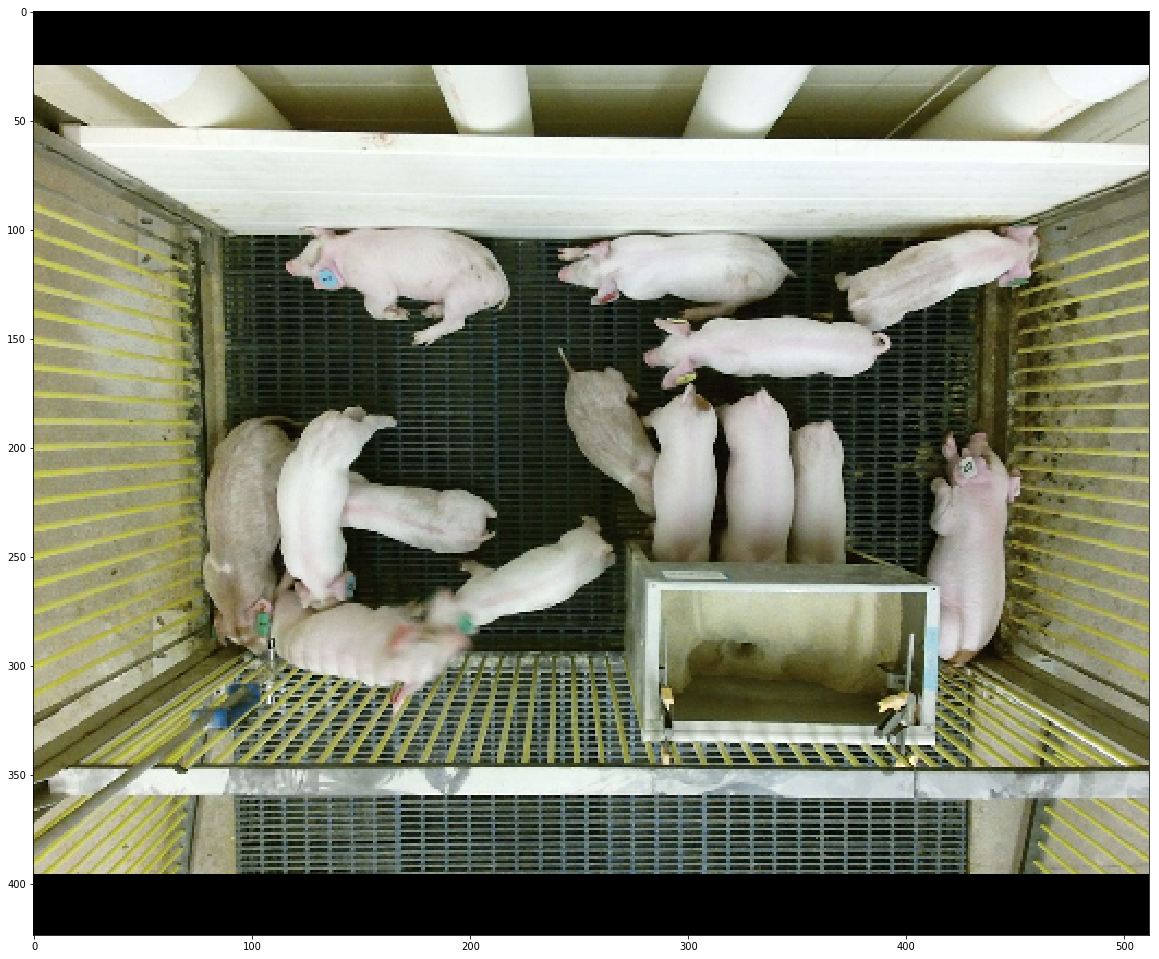

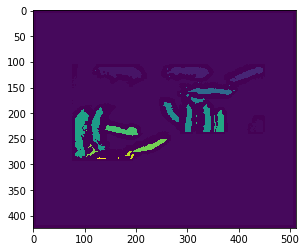

In [78]:
plt.figure(figsize=(20,10))
plt.imshow(normals[:,:,2]>0.3)
plt.title('Thresholded normals')
plt.show()

def filterAnimals(img, dom_th=0.3, perc_range=(0.001, 0.004)):
    cc = cv2.connectedComponents(img.astype(np.uint8))
    print(cc[1].shape)
    plt.imshow(cc[1])
    plt.title('Connectd components')
    plt.show()
    potentials = []
    
    j=1
    for i,val in enumerate(np.unique(cc[1])):
        # Size of the object
        perc = np.sum(cc[1]==val)/np.prod(cc[1].shape)
        if perc < perc_range[0] or perc > perc_range[1]:
            print('Perc: {}'.format(perc))
#            continue
        
        # Shape of the object
        p = np.where( cc[1]==val )
        p = np.stack( [ p[0], p[1] ], 1 )
        p = np.divide((p - np.mean(p, keepdims=True)), np.std(p, keepdims=True))
        cov = np.cov( np.transpose(p) )
        # Check for dominant component
        dom = np.max(np.abs(cov))
        if dom < dom_th:
#            continue
            print('DOM {}'.format(dom))
            
        potentials.append( (cc[1]==val)*j )
        j+=1
    return potentials
        
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()
    
kernel = np.ones((5,5),np.uint8)
    
potentials = filterAnimals(normals[:,:,2]>0.2)
potentials_mask = np.copy(img)*0
for m in potentials:
    mex = cv2.morphologyEx(m.astype(np.float32), cv2.MORPH_CLOSE, kernel)
    mex = cv2.dilate(mex,kernel,iterations = 4)
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(m)
    plt.subplot(1,2,2)
    plt.imshow(mex )
    potentials_mask = np.multiply(potentials_mask, potentials_mask>0) + np.multiply(m, potentials_mask==0)
    plt.show()

    
print(np.max(normals[:,:,2]))
print(np.min(normals[:,:,2]))

plt.figure(figsize=(20,20))
plt.imshow(np.multiply(img_col_trans, np.stack([potentials_mask>0]*3, axis=2)).astype(np.uint8))

plt.show()

plt.imshow(potentials_mask)
plt.show()

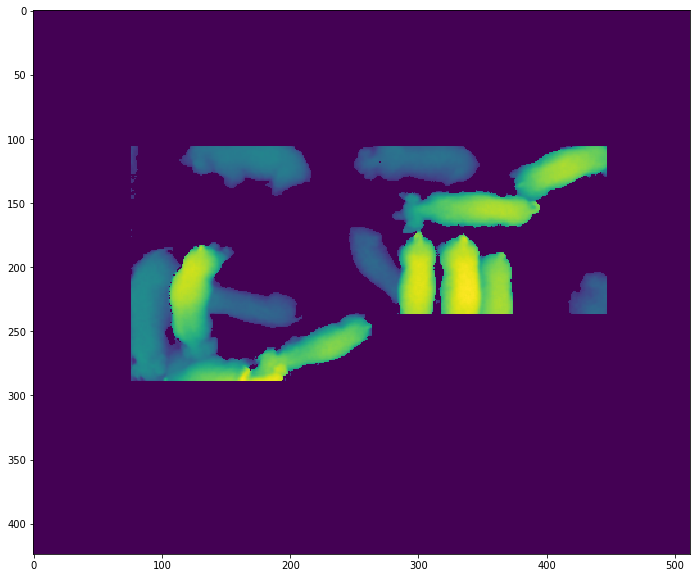

(424, 512)
meh
meh
meh
meh
meh
meh
meh


c:\anaconda\envs\ml\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
c:\anaconda\envs\ml\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\anaconda\envs\ml\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
c:\anaconda\envs\ml\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


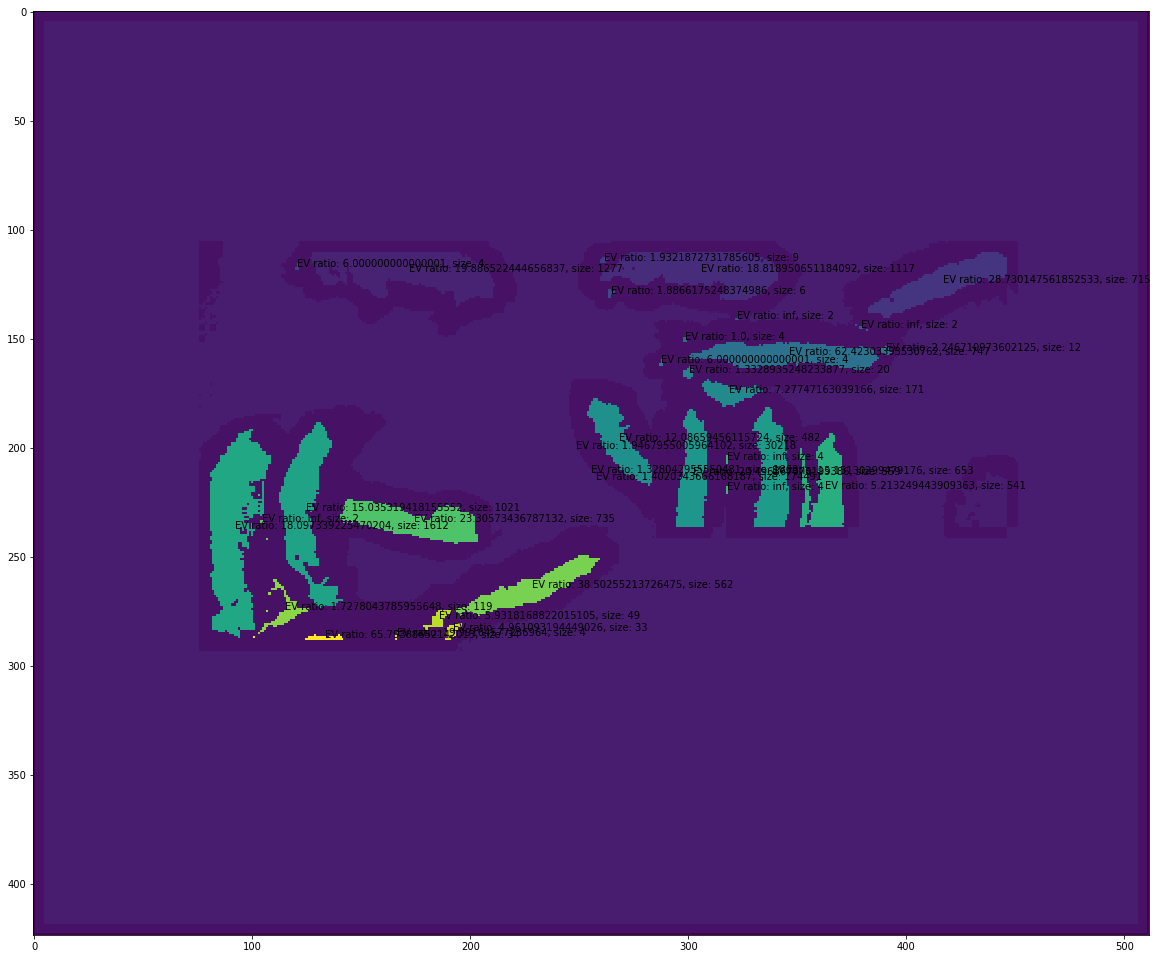

In [77]:


out = cv2.watershed( np.stack([img]*3, axis=2).astype(np.uint8), np.array(potentials_mask ).astype(np.int32) )
#out = cv2.watershed( img.astype(np.uint8), np.array(potentials_mask ).astype(np.int32) )

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()


plt.figure(figsize=(20,20))
plt.imshow(out)

print(out.shape)
    
for val in np.unique(out):
    try:
        yx = np.where( out == val)
        xy = np.stack([ yx[1], yx[0] ],1  )
        xym = [ np.mean(xy[:,0]), np.mean(xy[:,1]) ]
        xyt = np.transpose(xy)
        cor = np.cov( np.divide(xyt-np.mean(xyt, keepdims=True), np.std(xyt, keepdims=True))  )
        eigenvalues, eigenvectors = np.linalg.eig(cor)
        eigenvalues = np.sort(eigenvalues)
        ev_ratio = eigenvalues[1]/eigenvalues[0]
        s = np.sum(out==val)
        plt.text( xym[0], xym[1], 'EV ratio: {}, size: {}'.format(ev_ratio, s), color='black' )
    except:
        print('meh')
plt.show()
    

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

kernel = np.ones((13,13),np.uint8)
gradient = img
gradient = cv2.morphologyEx(gradient, cv2.MORPH_GRADIENT, kernel)
gradient = cv2.morphologyEx(gradient, cv2.MORPH_GRADIENT, kernel)
gradient = cv2.morphologyEx(gradient, cv2.MORPH_GRADIENT, kernel)
gradient = cv2.morphologyEx(gradient, cv2.MORPH_GRADIENT, kernel)
gradient = cv2.morphologyEx(gradient, cv2.MORPH_GRADIENT, kernel)
gradient = cv2.morphologyEx(gradient, cv2.MORPH_GRADIENT, kernel)
gradient = cv2.morphologyEx(gradient, cv2.MORPH_GRADIENT, kernel)
gradient = cv2.morphologyEx(gradient, cv2.MORPH_GRADIENT, kernel)
gradient = cv2.morphologyEx(gradient, cv2.MORPH_GRADIENT, kernel)


plt.figure(figsize=(20,10))
plt.imshow(gradient)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow( img>0 )
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(normals[:,:,2]<0.2)
plt.title('Normals')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow( np.multiply( img, normals[:,:,2]>0.2 ) )
plt.title('Depth separated by normals')
plt.show()



l = cv2.Laplacian(img, cv2.CV_32F)
plt.figure(figsize=(20,10))
plt.imshow(  l )
plt.title('Laplacian')
plt.show()

print(np.max(l))
print(np.min(l))


mask_edged = np.multiply( img>0, np.abs(l)<40 )
plt.figure(figsize=(20,10))
plt.imshow(mask_edged)
plt.show()

In [ ]:

K_Color_inv = linalg.inv(K_Color)

print('K Color:')
print(K_Color)

print('Inv K Color:')
print( K_Color_inv )

print('Color Image shape ' + str(img_col.shape))
P = np.zeros( ( img_col.shape[0]*img_col.shape[1],3 ), dtype=np.float32 )
i = 0
for x in range(img_col.shape[1]):
    for y in range(img_col.shape[0]):
        P[i,0] = x
        P[i,1] = y
        P[i,2] = 1
        i+=1

        
#P = np.array( [ 1, 1080, 1 ], dtype=np.float32 )        
#P = np.reshape(P, (1,3))        
        
print('P shape:')
print(P.shape)
P_out = np.matmul(  K_Color_inv, np.transpose(P) )
P_out = np.transpose(P_out)
print(P_out.shape)
for i in range(0, P_out.shape[0]):
    s = 2500.0/P_out[i,2]
    P_out[i,0] = P_out[i,0]*s
    P_out[i,1] = P_out[i,1]*s
    P_out[i,2] = P_out[i,2]*s

In [ ]:
print(P_out)

In [ ]:
I = np.eye(3, dtype=np.float32)
C = np.array( [ 40, 0,0 ], dtype=np.float32 )
IC = np.zeros((3,4), dtype=np.float32)
IC[0:3, 0:3] = I
IC[0, 3] = -40.0

print('IC')
print(IC)

KIC = np.matmul(K_IR, IC)

print(KIC)
print(KIC.shape)

In [ ]:



o = np.ones((P_out.shape[0],1), dtype=np.float32)
P_out_4D = np.hstack((P_out, o))
print(P_out_4D)
print(P_out_4D.shape)


if 0:
    P_out_4D = np.array(  [ 0,0,2500,1 ], dtype=np.float32)
    P_out_4D = np.reshape( P_out_4D, (1,4) )
    print(P_out_4D.shape)


out = np.matmul( KIC, np.transpose(P_out_4D))
print('out shape:')
print(out.shape)
out = np.transpose(out)
for i in range(0, out.shape[0]):
    out[i, 0] = out[i,0]/out[i,2]
    out[i, 1] = out[i,1]/out[i,2]
    out[i, 2] = out[i,2]/out[i,2]


# Actual center of IR image 243.892, 208.922
print('Final=')
print(out)

In [ ]:
def sub2ind(array_shape, rows, cols):
    ind = rows*array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    return ind

def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = (ind.astype('int') / array_shape[1])
    cols = ind % array_shape[1]
    return (rows, cols)

In [ ]:
img_ir = np.array(Image.open(image_ir), dtype=np.float32)
print(img_ir.shape)


print(P.shape)
print(out.shape)




img = np.zeros( (img_ir.shape[0], img_ir.shape[1], 3) )
for i in range(0, out.shape[0]):
    p_out = out[i,:].astype(np.int64)
    p_in = P[i,:].astype(np.int64)

    try :
#        print( str(p_out) + ' <- ' + str(p_in) + ', color: ' + str(img_col[p_in[0], p_in[1], :]) )
        #if(p_out[0] < 0) | (p_out[1] < 0) | (p_in[0]<0) | (p_in[1]<0) | (p_out[0]>=img.shape[0]) | (p_out[1]>=img.shape[1]):
         #   continue;
        
        
        img[ p_out[1], p_out[0],: ] = img_col[ p_in[1], p_in[0], : ]
        #print( 'Input image: ' + str( p_in[0:2] ) + ' -> ' + str(p_out[0:2]) )
    
    except:
        continue
        #print('Out of bounds')
    

plt.imshow(img_ir, cmap='gray')
plt.show()

plt.imshow(img_col.astype(np.uint8))
plt.show()
plt.imshow(img.astype(np.uint8))
plt.show()   